<a href="https://www.kaggle.com/code/turkimariem/house-prices-prediction?scriptVersionId=99803267" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Load Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from numpy import isnan
# Statistics functions
from scipy.stats import norm
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# Exploratory data analysis

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1460, 81)

In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
test.shape

(1459, 80)

In [7]:
#Function to compare columns in two dataframes
def compare_columns(df1,df2):
    columns_1 = list(df1.columns) 
    columns_2 = list(df2.columns)
    same_columns=[]
    diff_columns_2=[]
    diff_columns_1=[]

    for col in columns_2:
        if col in columns_1:
            same_columns.append(col)
        else:
            diff_columns_2.append(col)
    for col in columns_1:
        if col not in columns_2:
            diff_columns_1.append(col)
    return diff_columns_1, diff_columns_2

In [8]:
#Verify if we have the same columns in Train and Test datasets
diff_columns_train, diff_columns_test = compare_columns(train,test)
print(diff_columns_train)
print(diff_columns_test)

['SalePrice']
[]


We have the same columns in the 2 datasets

SalePrice is the variable to predict

In [9]:
nb_row=train.shape[0]
percentage_na_col_train=train.apply(lambda x:(x.notna().sum()/nb_row)*100,axis=0)

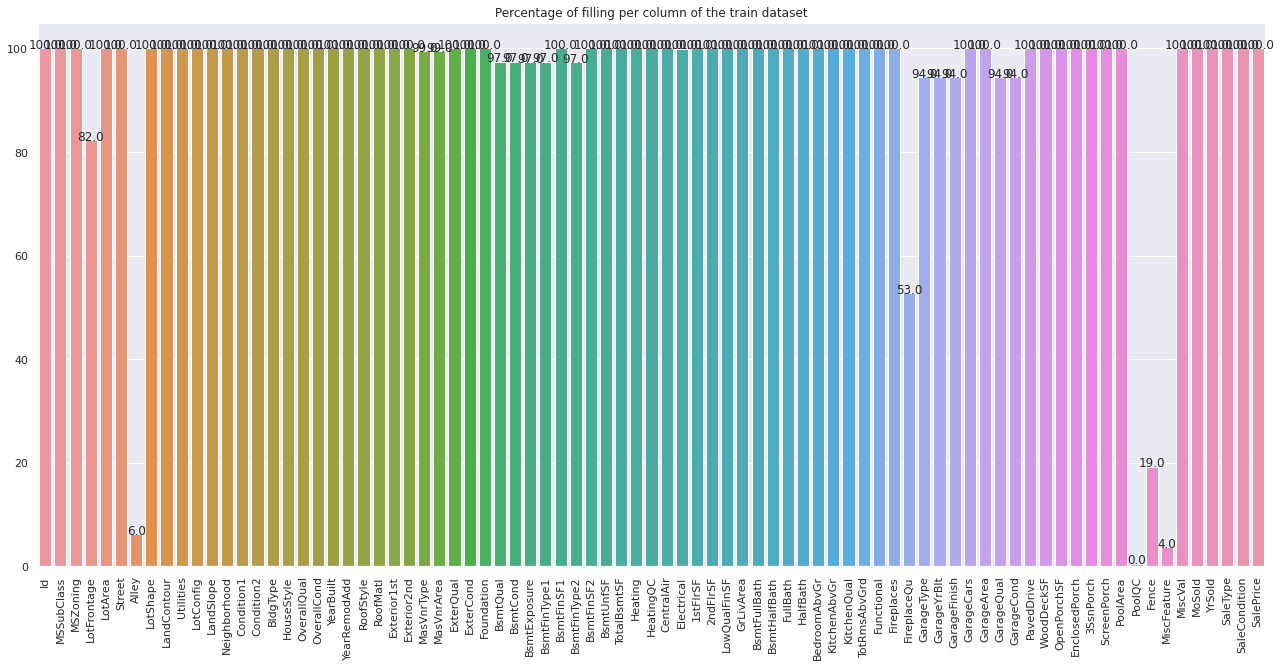

In [10]:
sns.set(font_scale=1)
plt.figure(figsize=(22,10))
plt.xticks(rotation=90)
nb_col=train.shape[1]
ax=sns.barplot(x=percentage_na_col_train.index,y=percentage_na_col_train.values)
i=0
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+0.4,height,round(percentage_na_col_train.values[i],0),ha='center')
    i+=1

plt.title('Percentage of filling per column of the train dataset')
plt.show()

In [11]:
nb_row_1=test.shape[0]
percentage_na_col_test=test.apply(lambda x:(x.notna().sum()/nb_row)*100,axis=0)

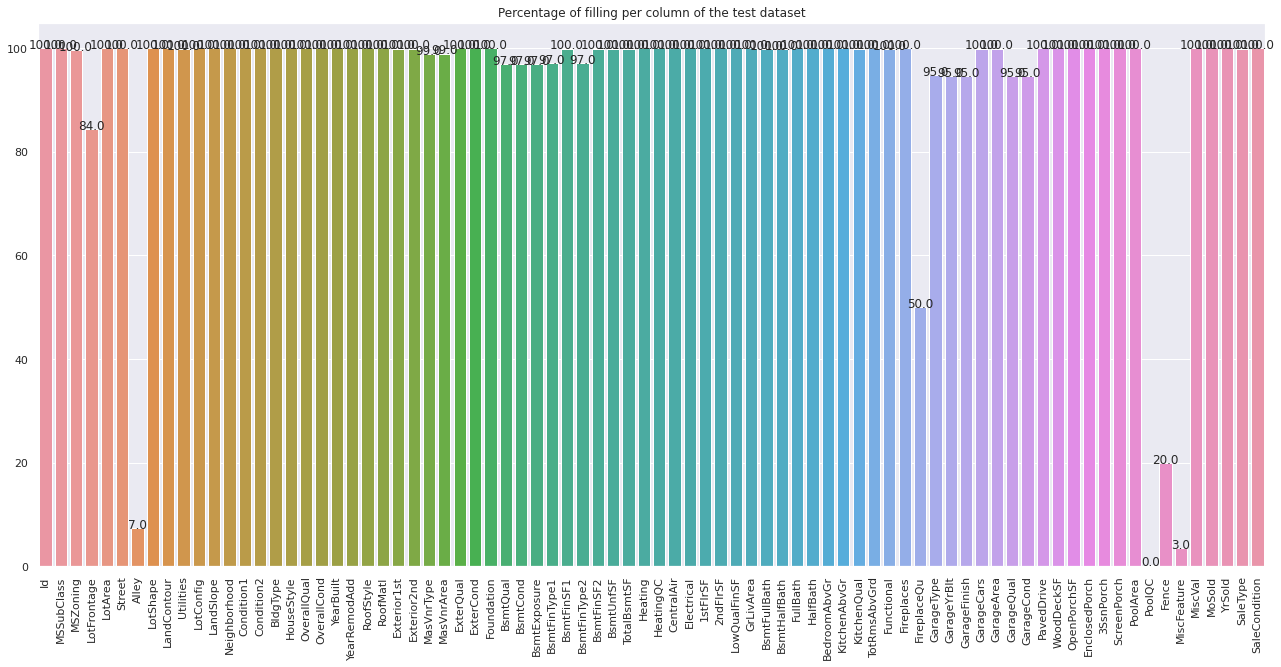

In [12]:
sns.set(font_scale=1)
plt.figure(figsize=(22,10))
plt.xticks(rotation=90)
nb_col_1=test.shape[1]
ax=sns.barplot(x=percentage_na_col_test.index,y=percentage_na_col_test.values)
i=0
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+0.4,height,round(percentage_na_col_test.values[i],0),ha='center')
    i+=1

plt.title('Percentage of filling per column of the test dataset')
plt.show()

***Drop columns which have more than 30 percent null values in train and test***

In [13]:
train.drop(columns=['PoolQC','Fence','MiscFeature','Alley','FireplaceQu'], axis =1 , inplace=True)
test.drop(columns=['PoolQC','Fence','MiscFeature','Alley','FireplaceQu'], axis =1 , inplace=True)

The ID is not a relevant feature needed to conduct the upcoming steps of the analysis so we will drop it

In [14]:
# Drop the 'Id' column from the train set
train.drop(["Id"], axis=1, inplace=True)

# Save the list of 'Id' before dropping it from the test set
Id_test_list = test["Id"].tolist()
test.drop(["Id"], axis=1, inplace=True)

# Exploring and cleaning numerical features

In [15]:
train_num=train.select_dtypes(include=[np.number])
train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


we have 37 numerical independent variables in the train set

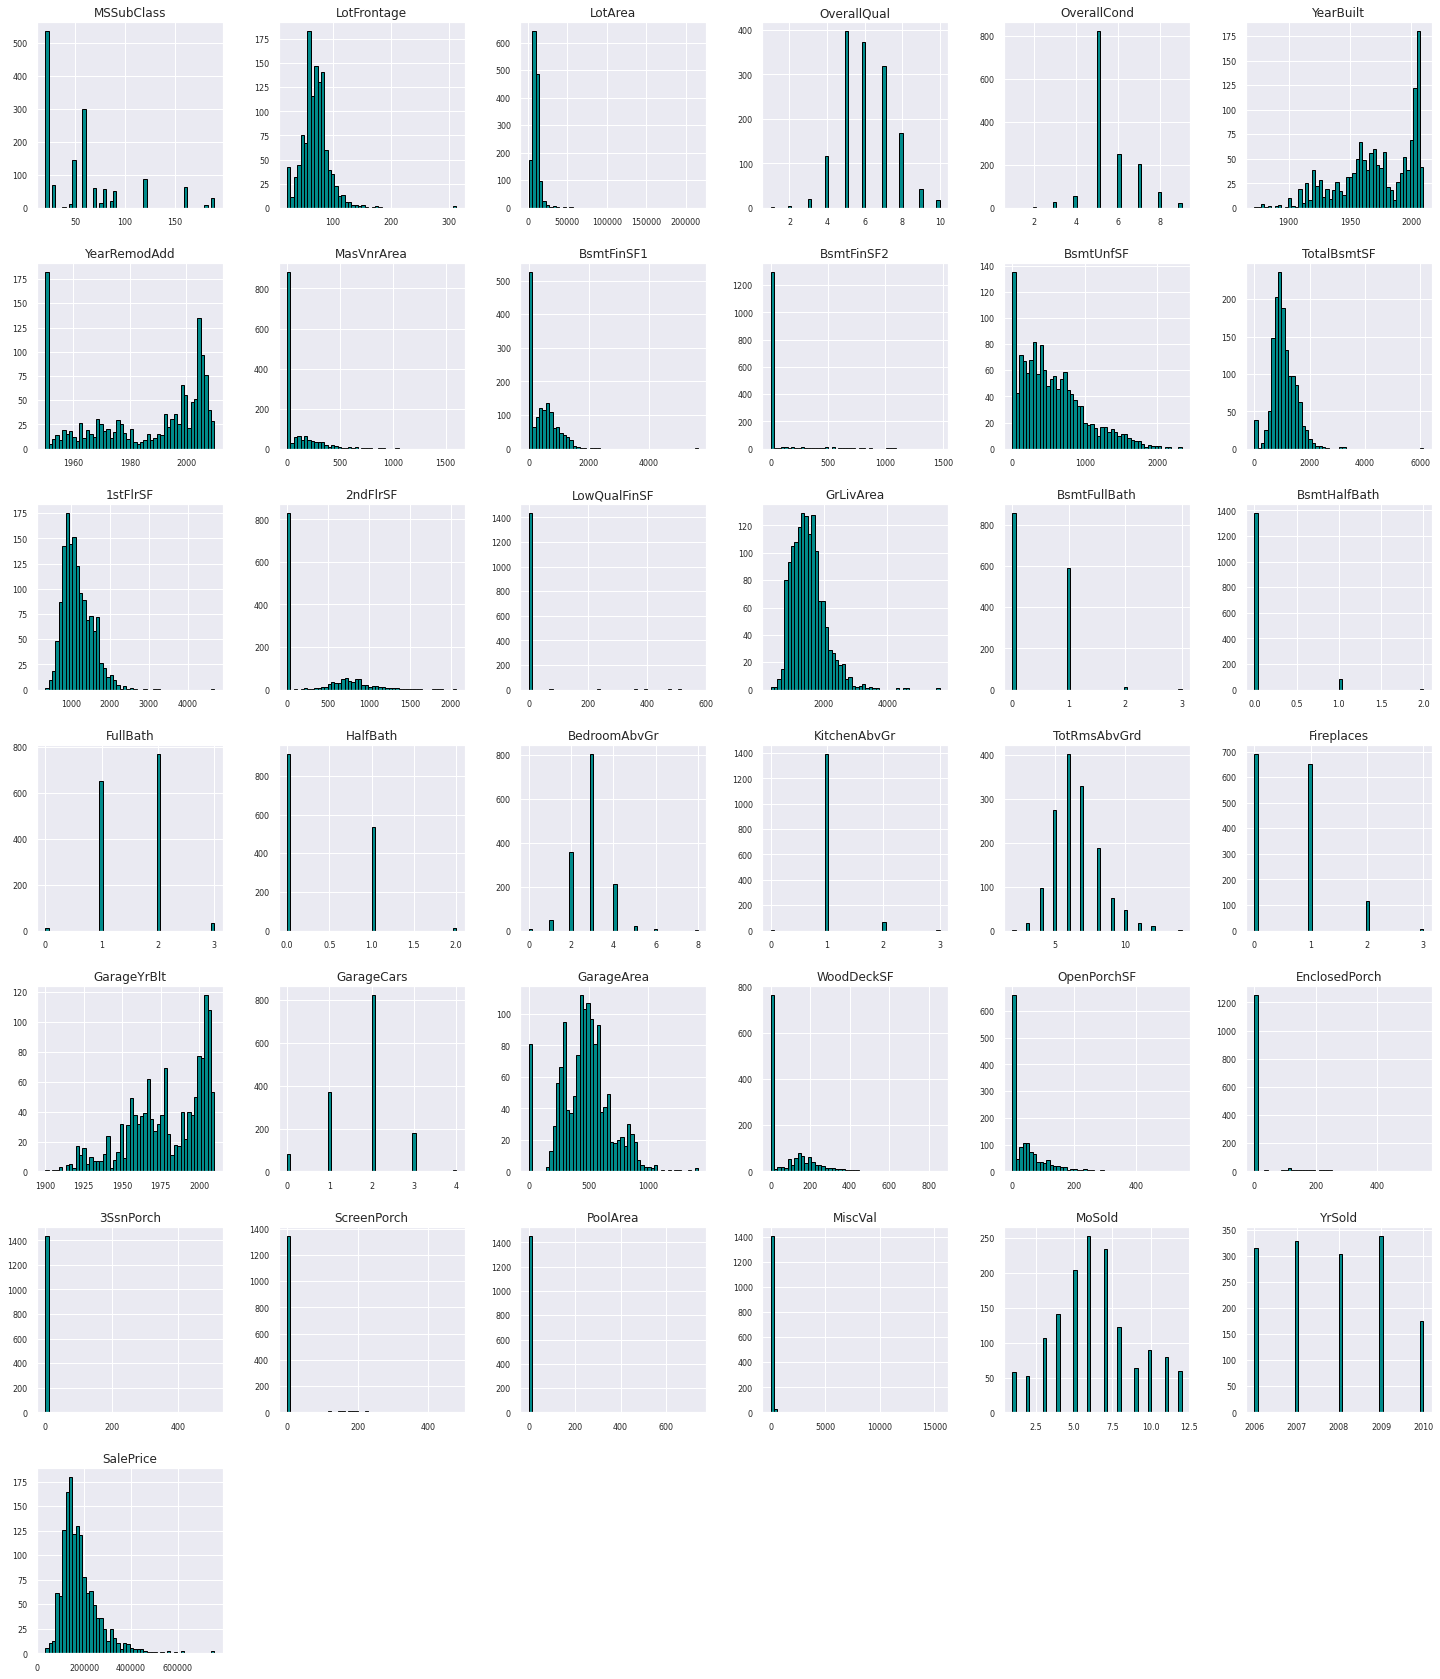

In [16]:
fig_ = train_num.hist(figsize=(25, 30), bins=50, color="darkcyan",
                         edgecolor="black", xlabelsize=8, ylabelsize=8)

In [17]:
test_num = test.select_dtypes(include=[np.number])
test_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,506.0,0,82,0,0,144,0,0,1,2010


we have 36 numerical independent variables in the test set

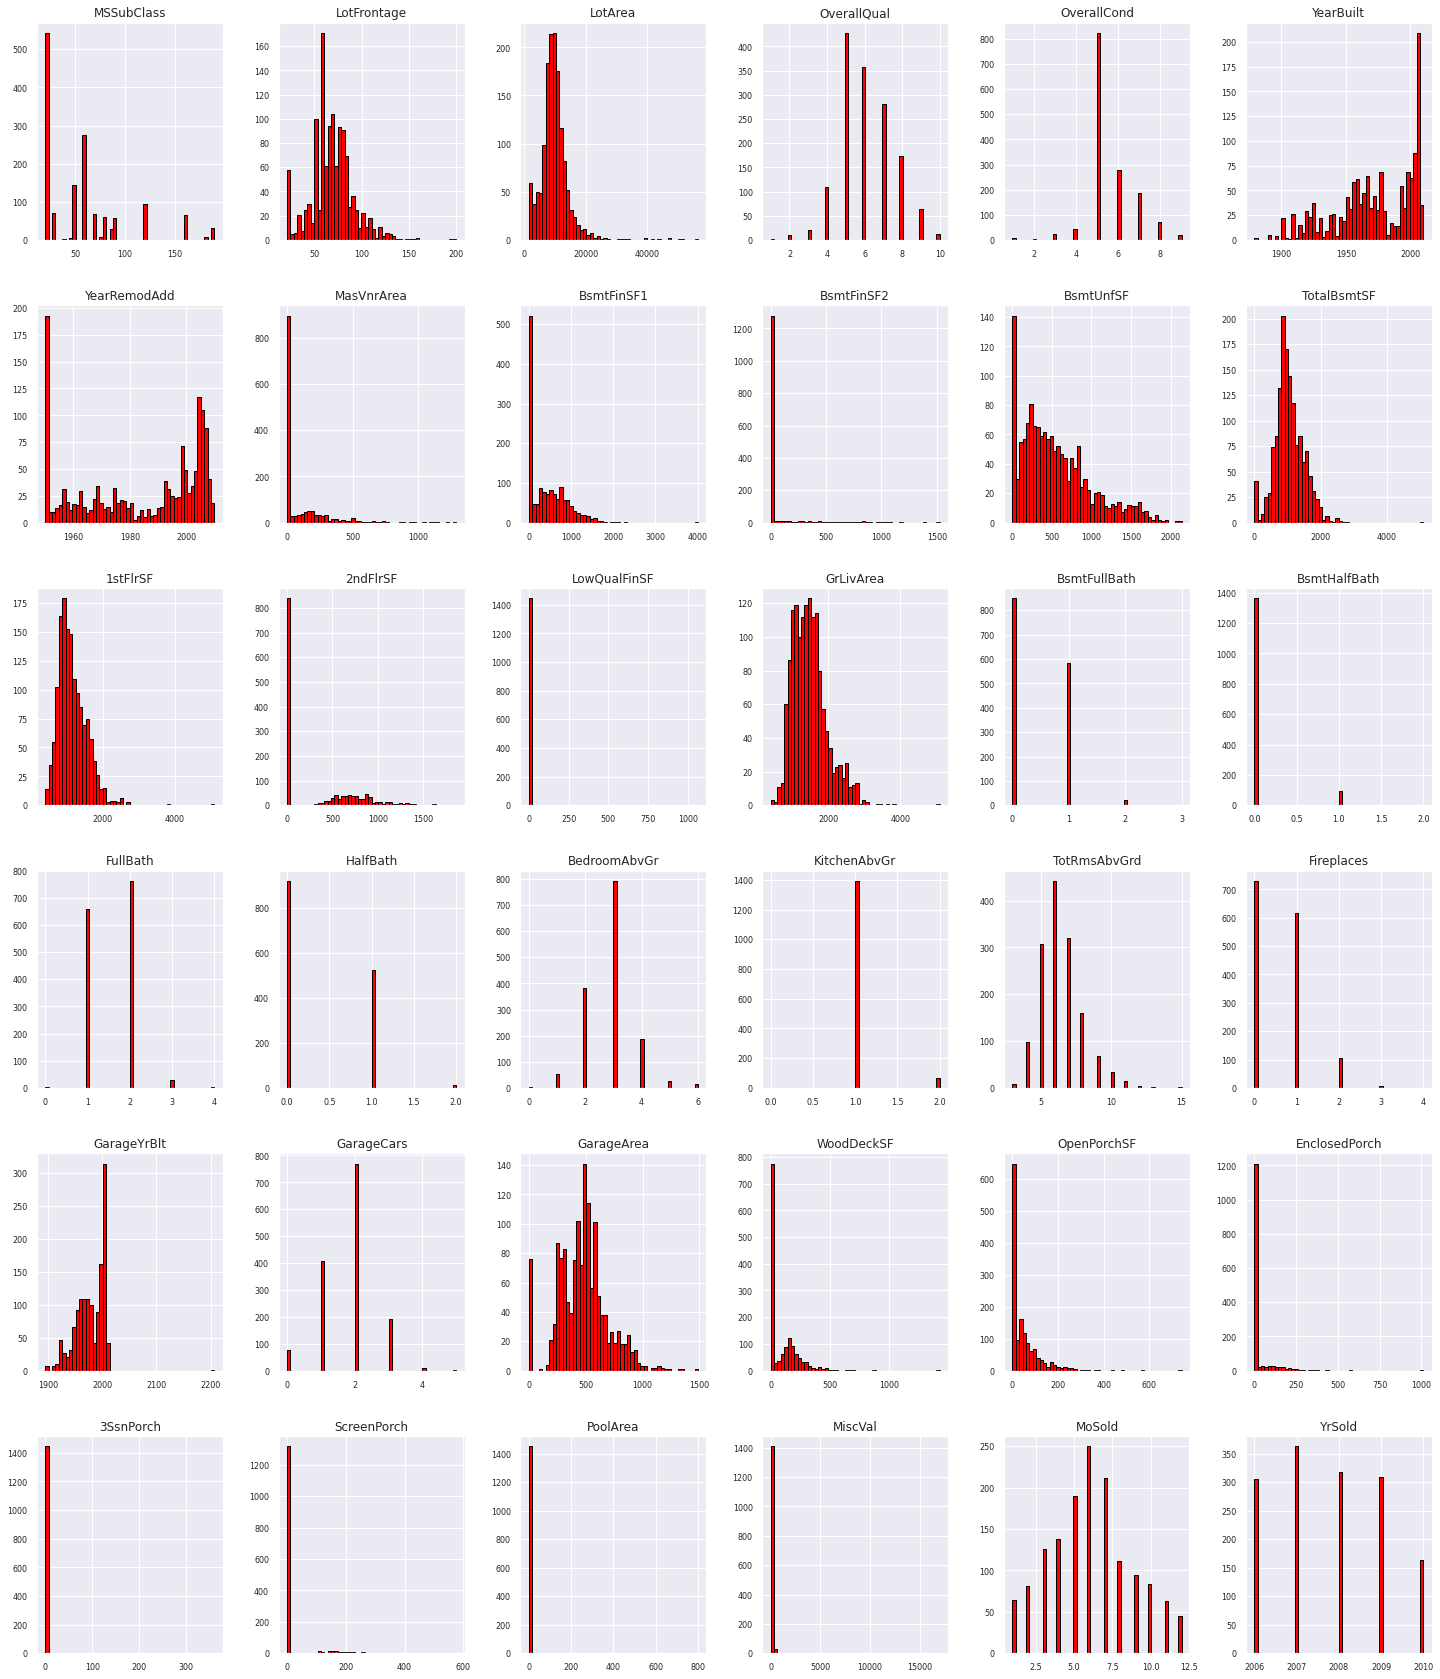

In [18]:
fig_ = test_num.hist(figsize=(25, 30), bins=50, color="red",
                         edgecolor="black", xlabelsize=8, ylabelsize=8)

Let's drop quasi-constant features where 95% of the values are similar or constant.

In [19]:
sel = VarianceThreshold(threshold=0.05) # 0.05: drop column where 95% of the values are constant

# fit finds the features with constant variance
sel.fit(train_num.iloc[:, :-1])


# Get the number of features that are not constant
print(f"Number of retained features: {sum(sel.get_support())}")

print(f"\nNumber of quasi_constant features: {len(train_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

quasi_constant_features_list = [x for x in train_num.iloc[:, :-1].columns if x not in train_num.iloc[:, :-1].columns[sel.get_support()]]

print(f"\nQuasi-constant features to be dropped: {quasi_constant_features_list}")

# Let's drop these columns from train_num
train_num.drop(quasi_constant_features_list, axis=1, inplace=True)

Number of retained features: 35

Number of quasi_constant features: 1

Quasi-constant features to be dropped: ['KitchenAbvGr']


In [20]:
# Checking the dimensions of the set obtained
print(train_num.shape)

(1460, 36)


In [21]:
sel = VarianceThreshold(threshold=0.05) # 0.05: drop column where 95% of the values are constant

# fit finds the features with constant variance
sel.fit(test_num.iloc[:, :-1])


# Get the number of features that are not constant
print(f"Number of retained features: {sum(sel.get_support())}")

print(f"\nNumber of quasi_constant features: {len(test_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

quasi_constant_features_list = [x for x in test_num.iloc[:, :-1].columns if x not in test_num.iloc[:, :-1].columns[sel.get_support()]]

print(f"\nQuasi-constant features to be dropped: {quasi_constant_features_list}")

# Let's drop these columns from test_num
test_num.drop(quasi_constant_features_list, axis=1, inplace=True)

Number of retained features: 34

Number of quasi_constant features: 1

Quasi-constant features to be dropped: ['KitchenAbvGr']


In [22]:
# Checking the dimensions of the set obtained
print(test_num.shape)

(1459, 35)


## Scatterplots: relationship with saleprice

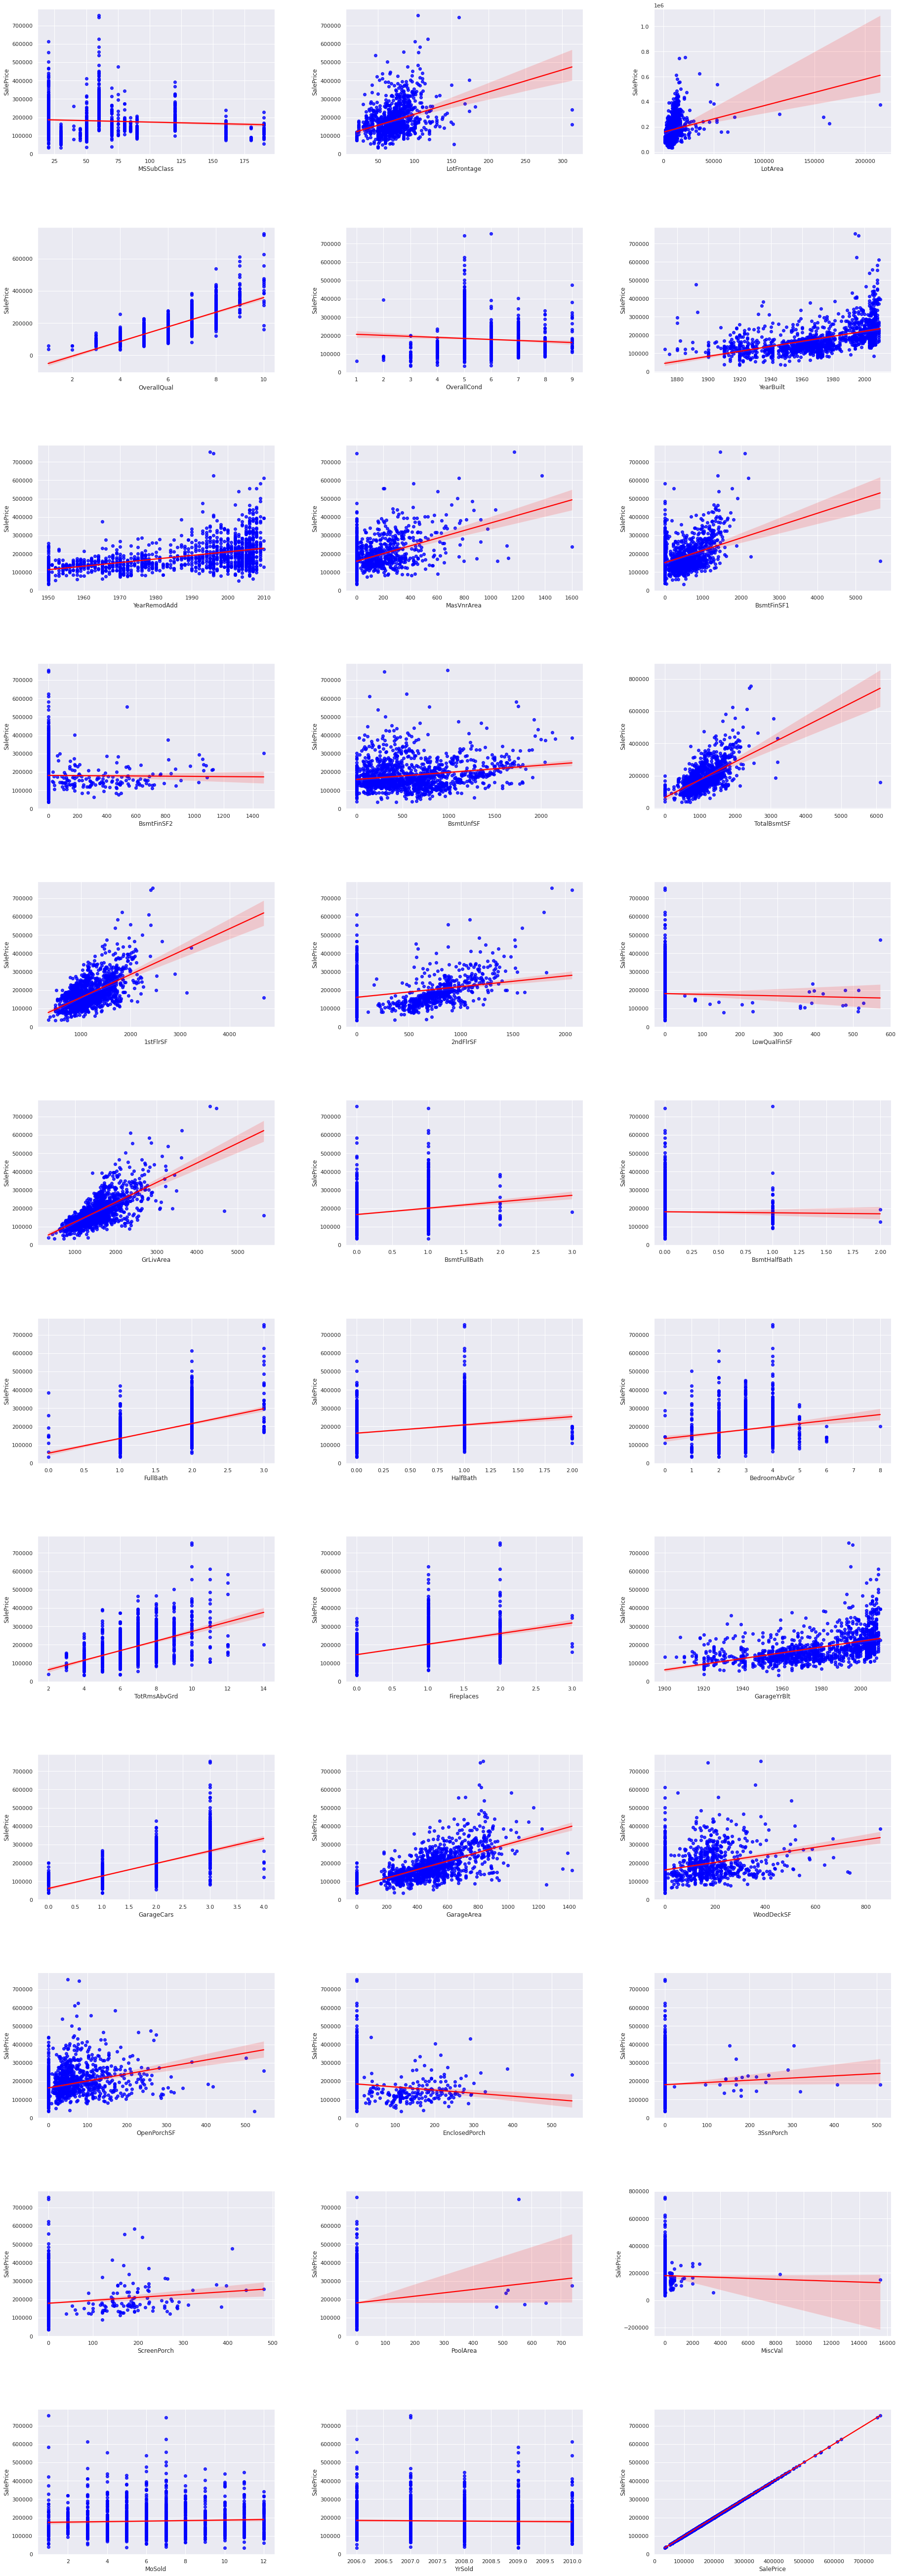

In [23]:
fig = plt.figure(figsize=(30,50))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.9,
                    wspace=0.3,
                    hspace=0.5)
for i, col in enumerate(train_num.columns):
        plt.subplot(15,3,i+1)
        sns.regplot(x=col, y= "SalePrice", data=train_num, scatter_kws={"color": "blue"}, line_kws={"color": "red"})


The red line shown on each graph is the fitted line from a linear regression.


## Heatmap

<AxesSubplot:>

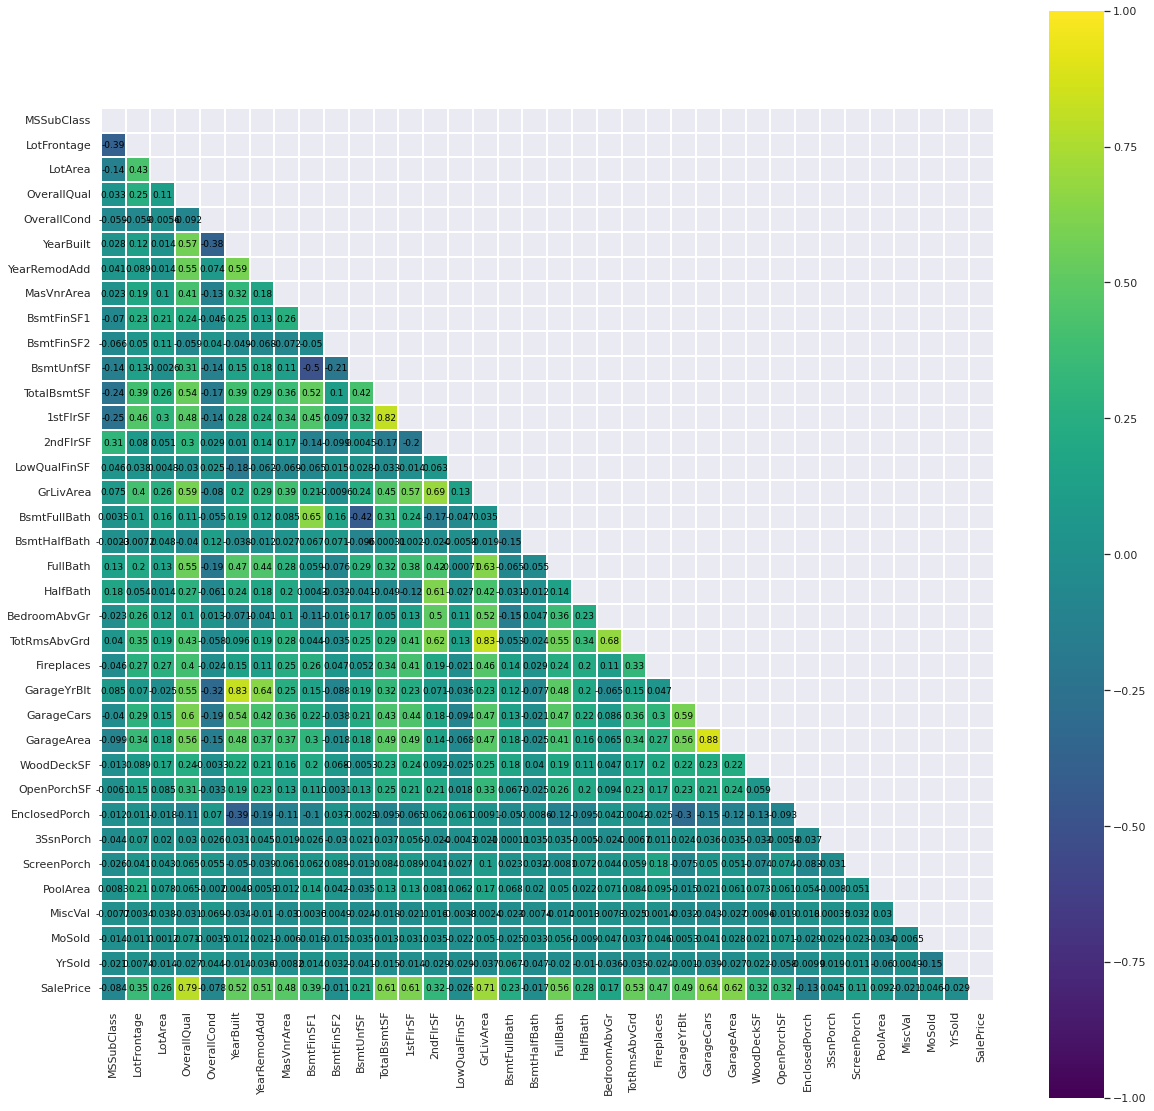

In [24]:
fig = plt.figure(figsize=(20,20))
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

# Define correlation matrix 
# (method = pearson: standard correlation coefficient)
corr_matrix = train_num.corr(method = 'pearson')

# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Choose the color map
cmap = "viridis"

# plot the heatmap
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"}, square=True, cmap=cmap, annot=True)

Correlation around 0.7 or above suggest a strong relationship and only one of the two variables is needed in the analysis

There is a strong linear relationship between the sale price, our target variable and predictors cited in a descent order:

The overall quality of the material : Rates the overall material and finish of the house (0.79)

The living area above ground (0.71)

***Between variables, we have a very strong positive correlation (of at least 0.7) including variable below also lined up in a descent order:***

"GarageArea" and "GarageCars" (0.88)

"GarageYrBlt" and "YearBuilt" (0.83)

"TotRmsAbvGrd" and "GrLivArea" (0.83)

"1stFlrSF" and "TotalBsmtSF"(0.82)

In [25]:
# Strongly Correlated Features
strong_feat = ["GarageArea", "GarageYrBlt", "1stFlrSF", "TotRmsAbvGrd"]
strong_feat

['GarageArea', 'GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd']

In [26]:
#Drop strongly correlated features
# Training set
for i, col in enumerate(strong_feat):
    if col in train_num.columns:
        train_num.drop(col, axis=1, inplace=True)

        # Testing set
for i, col in enumerate(strong_feat):
    if col in test_num.columns:
        test_num.drop(col, axis=1, inplace=True)

In [27]:
df_num_corr = train_num.corr()["SalePrice"][:-1]

#################################
# Correlated features (r2 < 0.3): very weak relationship with SalePrice
weak_features_list = df_num_corr[abs(df_num_corr) < 0.3].sort_values(ascending=False)
print(f"{len(weak_features_list)} weakly correlated values with SalePrice:\n{weak_features_list}\n")

weak_features = df_num_corr[abs(df_num_corr) < 0.3].index.tolist()
#weak_features.append("SalePrice")


17 weakly correlated values with SalePrice:
HalfBath         0.28
LotArea          0.26
BsmtFullBath     0.23
BsmtUnfSF        0.21
BedroomAbvGr     0.17
ScreenPorch      0.11
PoolArea         0.09
MoSold           0.05
3SsnPorch        0.04
BsmtFinSF2      -0.01
BsmtHalfBath    -0.02
MiscVal         -0.02
LowQualFinSF    -0.03
YrSold          -0.03
OverallCond     -0.08
MSSubClass      -0.08
EnclosedPorch   -0.13
Name: SalePrice, dtype: float64



In [28]:
# Remove 17 variables weakly correlated with SalePrice in train set
train_num.drop(columns=weak_features, inplace=True)

In [29]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   OverallQual   1460 non-null   int64  
 2   YearBuilt     1460 non-null   int64  
 3   YearRemodAdd  1460 non-null   int64  
 4   MasVnrArea    1452 non-null   float64
 5   BsmtFinSF1    1460 non-null   int64  
 6   TotalBsmtSF   1460 non-null   int64  
 7   2ndFlrSF      1460 non-null   int64  
 8   GrLivArea     1460 non-null   int64  
 9   FullBath      1460 non-null   int64  
 10  Fireplaces    1460 non-null   int64  
 11  GarageCars    1460 non-null   int64  
 12  WoodDeckSF    1460 non-null   int64  
 13  OpenPorchSF   1460 non-null   int64  
 14  SalePrice     1460 non-null   int64  
dtypes: float64(2), int64(13)
memory usage: 171.2 KB


we have kept 14 numercial columns

In [30]:
#Drop the same features
test_num.drop(columns=weak_features, inplace=True)

In [31]:
test_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1232 non-null   float64
 1   OverallQual   1459 non-null   int64  
 2   YearBuilt     1459 non-null   int64  
 3   YearRemodAdd  1459 non-null   int64  
 4   MasVnrArea    1444 non-null   float64
 5   BsmtFinSF1    1458 non-null   float64
 6   TotalBsmtSF   1458 non-null   float64
 7   2ndFlrSF      1459 non-null   int64  
 8   GrLivArea     1459 non-null   int64  
 9   FullBath      1459 non-null   int64  
 10  Fireplaces    1459 non-null   int64  
 11  GarageCars    1458 non-null   float64
 12  WoodDeckSF    1459 non-null   int64  
 13  OpenPorchSF   1459 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 159.7 KB


## Handling missing values of numerical features

Datasets may have missing values, and this can cause problems for many machine learning algorithms.

As such, it is good practice to identify and replace missing values for each column in our input data prior to modeling our prediction task. This is called missing data imputation.

## Training Dataset

In [32]:
print(train_num.isnull().sum(),'\n')

LotFrontage     259
OverallQual       0
YearBuilt         0
YearRemodAdd      0
MasVnrArea        8
BsmtFinSF1        0
TotalBsmtSF       0
2ndFlrSF          0
GrLivArea         0
FullBath          0
Fireplaces        0
GarageCars        0
WoodDeckSF        0
OpenPorchSF       0
SalePrice         0
dtype: int64 



In [33]:
nb_row=train_num.shape[0]
percentage_na_col_train=train_num.apply(lambda x:(x.notna().sum()/nb_row)*100,axis=0)

In [34]:
percentage_na_col_train

LotFrontage     82.26
OverallQual    100.00
YearBuilt      100.00
YearRemodAdd   100.00
MasVnrArea      99.45
BsmtFinSF1     100.00
TotalBsmtSF    100.00
2ndFlrSF       100.00
GrLivArea      100.00
FullBath       100.00
Fireplaces     100.00
GarageCars     100.00
WoodDeckSF     100.00
OpenPorchSF    100.00
SalePrice      100.00
dtype: float64

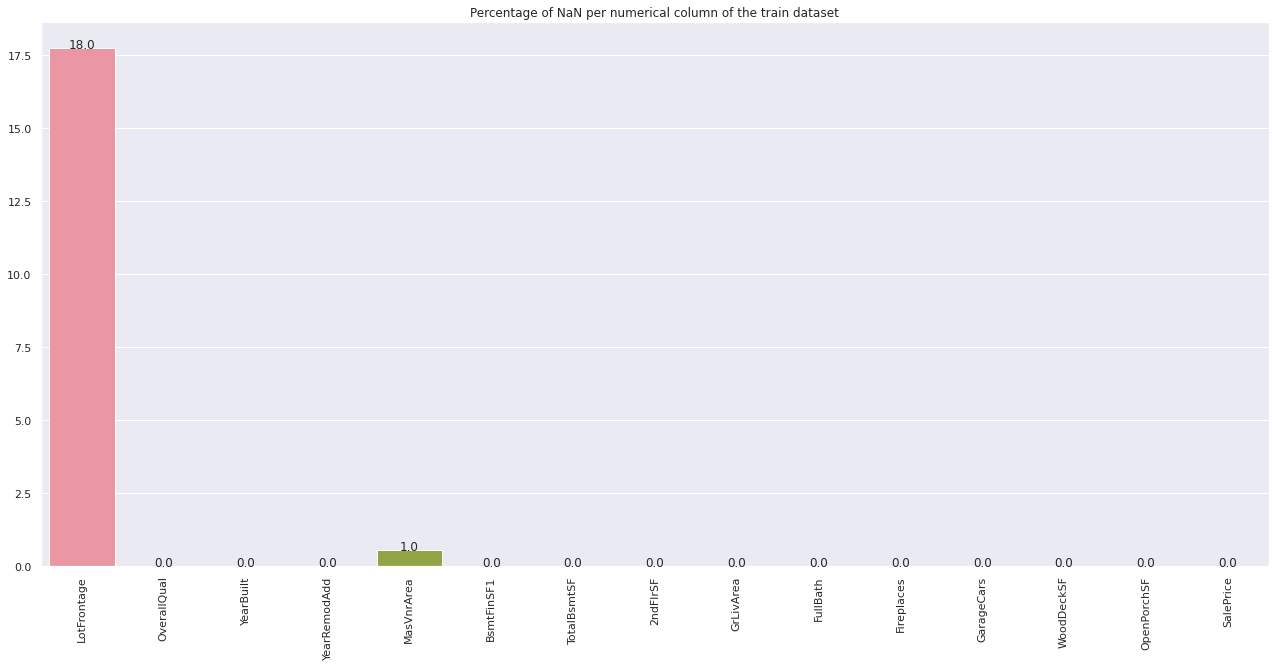

In [35]:
sns.set(font_scale=1)
plt.figure(figsize=(22,10))
plt.xticks(rotation=90)
nb_col=train_num.shape[1]
ax=sns.barplot(x=percentage_na_col_train.index,y=100-percentage_na_col_train.values)
i=0
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+0.4,height,round(100-percentage_na_col_train.values[i],0),ha='center')
    i+=1

plt.title('Percentage of NaN per numerical column of the train dataset')
plt.show()

Thus, from the graph obtained above, two numerical variables contain missing values:

The linear feet of street connected to property (18%)

The masonry veneer area (1%)

A possible solution to fix this problem is about filling the missing values by the median because the distributions of both variables are skewed.

### Impute with SimpleImputer

#### Median:

In [36]:
# Imputation of missing values (NaNs) with SimpleImputer
my_imputer = SimpleImputer(strategy="median")
df_train_imputed = pd.DataFrame(my_imputer.fit_transform(train_num))
df_train_imputed.columns = train_num.columns

Let's look at the distibutions of these features before and after imputation.

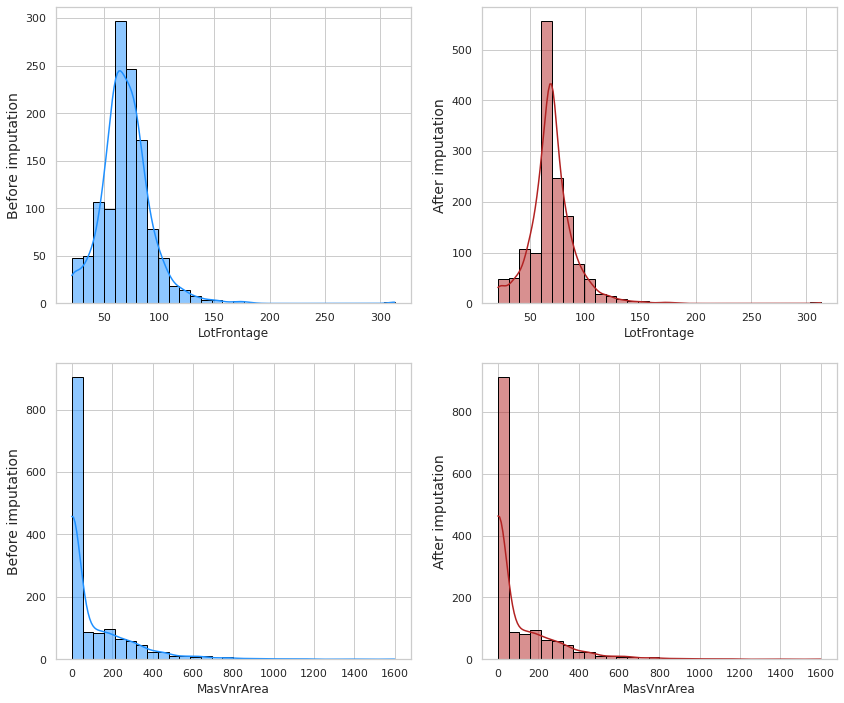

In [37]:
# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "MasVnrArea"], [0, 1]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=train_num[feature],
                     kde=True, bins=30, color="dodgerblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_train_imputed[feature],
                     kde=True, bins=30, color="firebrick", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

The shape of the first distribution is affected by this imputation performed on the observations.

Consequently, this operation is a failure on the first variable and we can't consequently proceed with that.

#### Most frequent

In [38]:
# Imputation of missing values (NaNs) with SimpleImputer
my_imputer = SimpleImputer(strategy="most_frequent")
df_train_imputed_1 = pd.DataFrame(my_imputer.fit_transform(train_num))
df_train_imputed_1.columns = train_num.columns

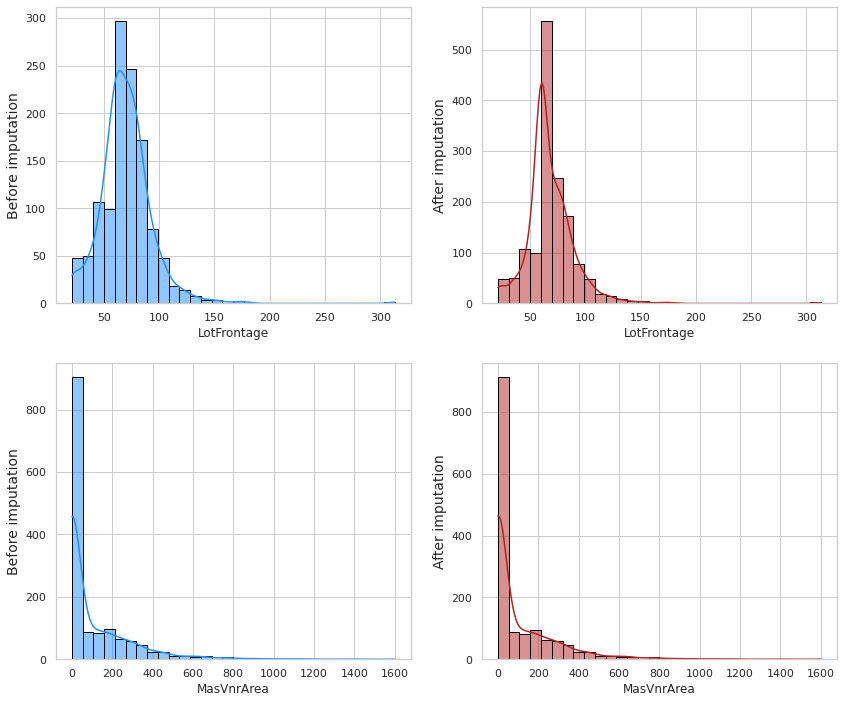

In [39]:
# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "MasVnrArea"], [0, 1]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=train_num[feature],
                     kde=True, bins=30, color="dodgerblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_train_imputed_1[feature],
                     kde=True, bins=30, color="firebrick", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

### Impute with KNN Imputer

In [40]:
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(train_num)
# transform the dataset
Xtrans = imputer.transform(train_num)
train_num_imputed=pd.DataFrame(Xtrans, columns=train_num.columns).astype(train_num.dtypes.to_dict())
train_num_imputed


,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,2ndFlrSF,GrLivArea,FullBath,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice
0,65.00,7,2003,2003,196.00,706,856,854,1710,2,0,2,0,61,208500
1,80.00,6,1976,1976,0.00,978,1262,0,1262,2,1,2,298,0,181500
2,68.00,7,2001,2002,162.00,486,920,866,1786,2,1,2,0,42,223500
3,60.00,7,1915,1970,0.00,216,756,756,1717,1,1,3,0,35,140000
4,84.00,8,2000,2000,350.00,655,1145,1053,2198,2,1,3,192,84,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.00,6,1999,2000,0.00,0,953,694,1647,2,1,2,0,40,175000
1456,85.00,6,1978,1988,119.00,790,1542,0,2073,2,2,2,349,0,210000
1457,66.00,7,1941,2006,0.00,275,1152,1152,2340,2,2,1,0,60,266500
1458,68.00,5,1950,1996,0.00,49,1078,0,1078,1,0,1,366,0,142125


In [41]:
nb_row=train_num_imputed.shape[0]
percentage_na_col_train=train_num_imputed.apply(lambda x:(x.notna().sum()/nb_row)*100,axis=0)
percentage_na_col_train

LotFrontage    100.00
OverallQual    100.00
YearBuilt      100.00
YearRemodAdd   100.00
MasVnrArea     100.00
BsmtFinSF1     100.00
TotalBsmtSF    100.00
2ndFlrSF       100.00
GrLivArea      100.00
FullBath       100.00
Fireplaces     100.00
GarageCars     100.00
WoodDeckSF     100.00
OpenPorchSF    100.00
SalePrice      100.00
dtype: float64

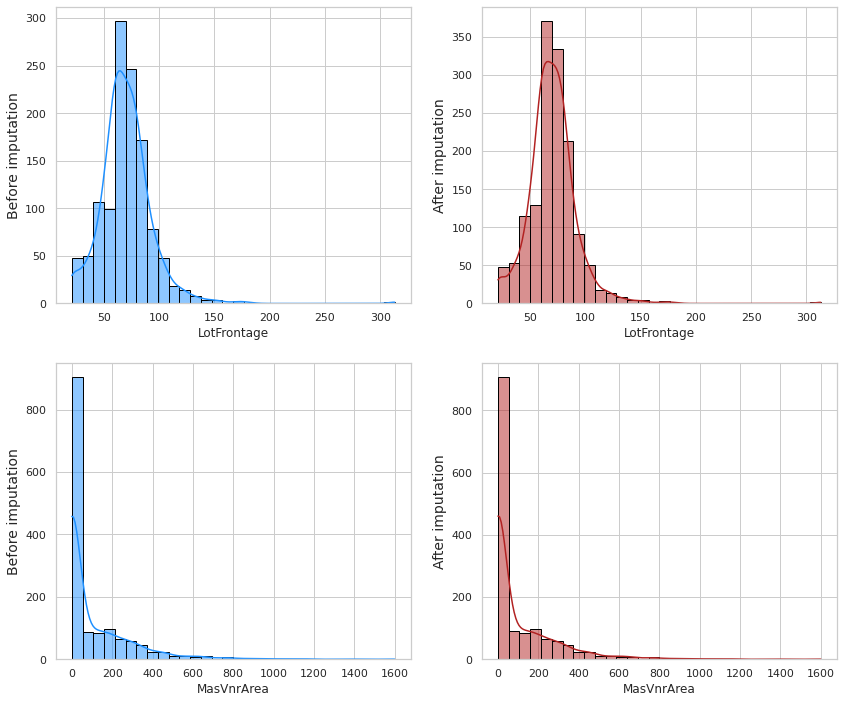

In [42]:
# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "MasVnrArea"], [0, 1]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=train_num[feature],
                     kde=True, bins=30, color="dodgerblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=train_num_imputed[feature],
                     kde=True, bins=30, color="firebrick", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

We observe that KNN imputation gives better results and the trajectory of the distribution of the two variables remains untouched

## Testing dataset

In [43]:
nb_row_test=test_num.shape[0]
percentage_na_col_test=test_num.apply(lambda x:(x.notna().sum()/nb_row_test)*100,axis=0)

In [44]:
percentage_na_col_test

LotFrontage     84.44
OverallQual    100.00
YearBuilt      100.00
YearRemodAdd   100.00
MasVnrArea      98.97
BsmtFinSF1      99.93
TotalBsmtSF     99.93
2ndFlrSF       100.00
GrLivArea      100.00
FullBath       100.00
Fireplaces     100.00
GarageCars      99.93
WoodDeckSF     100.00
OpenPorchSF    100.00
dtype: float64

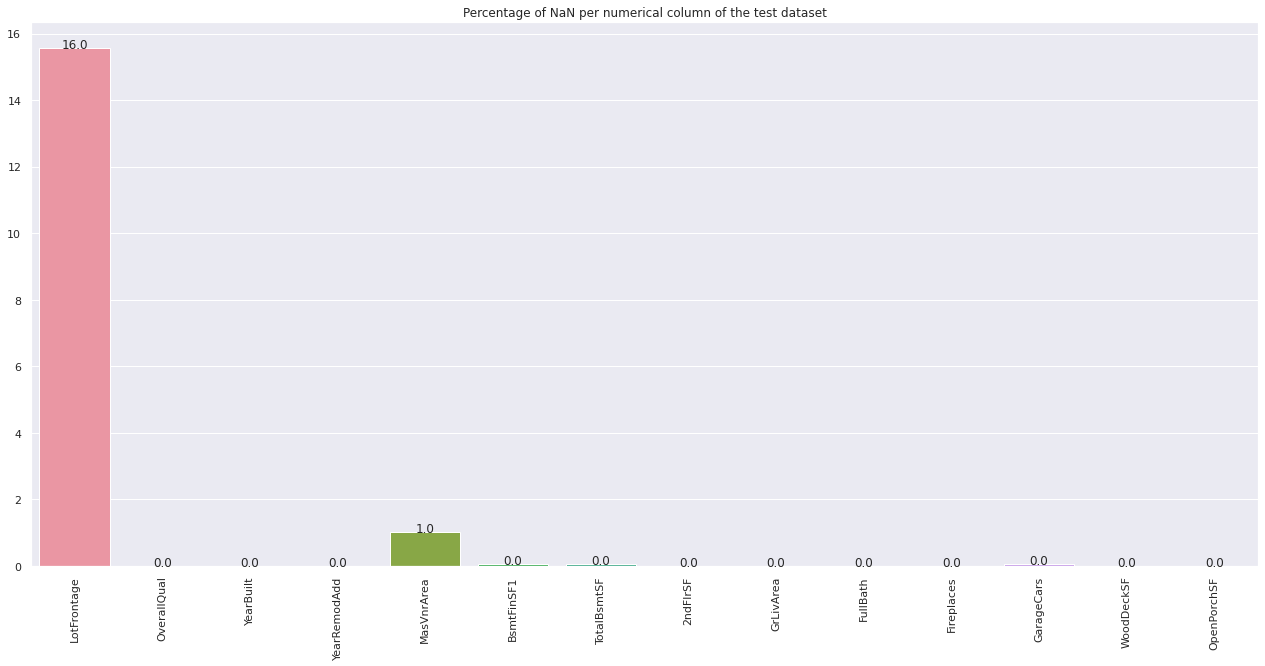

In [45]:
sns.set(font_scale=1)
plt.figure(figsize=(22,10))
plt.xticks(rotation=90)
nb_col_test=test_num.shape[1]
ax=sns.barplot(x=percentage_na_col_test.index,y=100-percentage_na_col_test.values)
i=0
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+0.4,height,round(100-percentage_na_col_test.values[i],0),ha='center')
    i+=1

plt.title('Percentage of NaN per numerical column of the test dataset')
plt.show()    

In conntrast to the training set, here we have 5 features containing missing values in their observations. 

So, let's apply the same procedure, that's KNN imputation.

In [46]:
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(test_num)
# transform the dataset
Xtest = imputer.transform(test_num)
test_num_imputed=pd.DataFrame(Xtest, columns=test_num.columns).astype(test_num.dtypes.to_dict())
test_num_imputed


,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,2ndFlrSF,GrLivArea,FullBath,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF
0,80.00,5,1961,1961,0.00,468.00,882.00,0,896,1,0,1.00,140,0
1,81.00,6,1958,1958,108.00,923.00,"1,329.00",0,1329,1,0,1.00,393,36
2,74.00,5,1997,1998,0.00,791.00,928.00,701,1629,2,1,2.00,212,34
3,78.00,6,1998,1998,20.00,602.00,926.00,678,1604,2,1,2.00,360,36
4,43.00,8,1992,1992,0.00,263.00,"1,280.00",0,1280,2,0,2.00,0,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.00,4,1970,1970,0.00,0.00,546.00,546,1092,1,0,0.00,0,0
1455,21.00,4,1970,1970,0.00,252.00,546.00,546,1092,1,0,1.00,0,24
1456,160.00,5,1960,1996,0.00,"1,224.00","1,224.00",0,1224,1,1,2.00,474,0
1457,62.00,5,1992,1992,0.00,337.00,912.00,0,970,1,0,0.00,80,32


# Explore and clean Categorical features


In [47]:
categorical_features = [i for i in train.columns if train.dtypes[i] == "object"]
categorical_features.append("SalePrice")

# Train set
df_train_categ = train[categorical_features]

# Test set (-1 because test set don't have 'Sale Price')
df_test_categ = test[categorical_features[:-1]]

In [48]:
print(f"Training set shape (Categorical features): {df_train_categ.shape}\n")
print(f"Test set shape (Categorical features): {df_test_categ.shape}\n")

Training set shape (Categorical features): (1460, 39)

Test set shape (Categorical features): (1459, 38)



As displayed, we have 39 categorical varaibles in the training data set as well as in the testing data set.

## Count plots

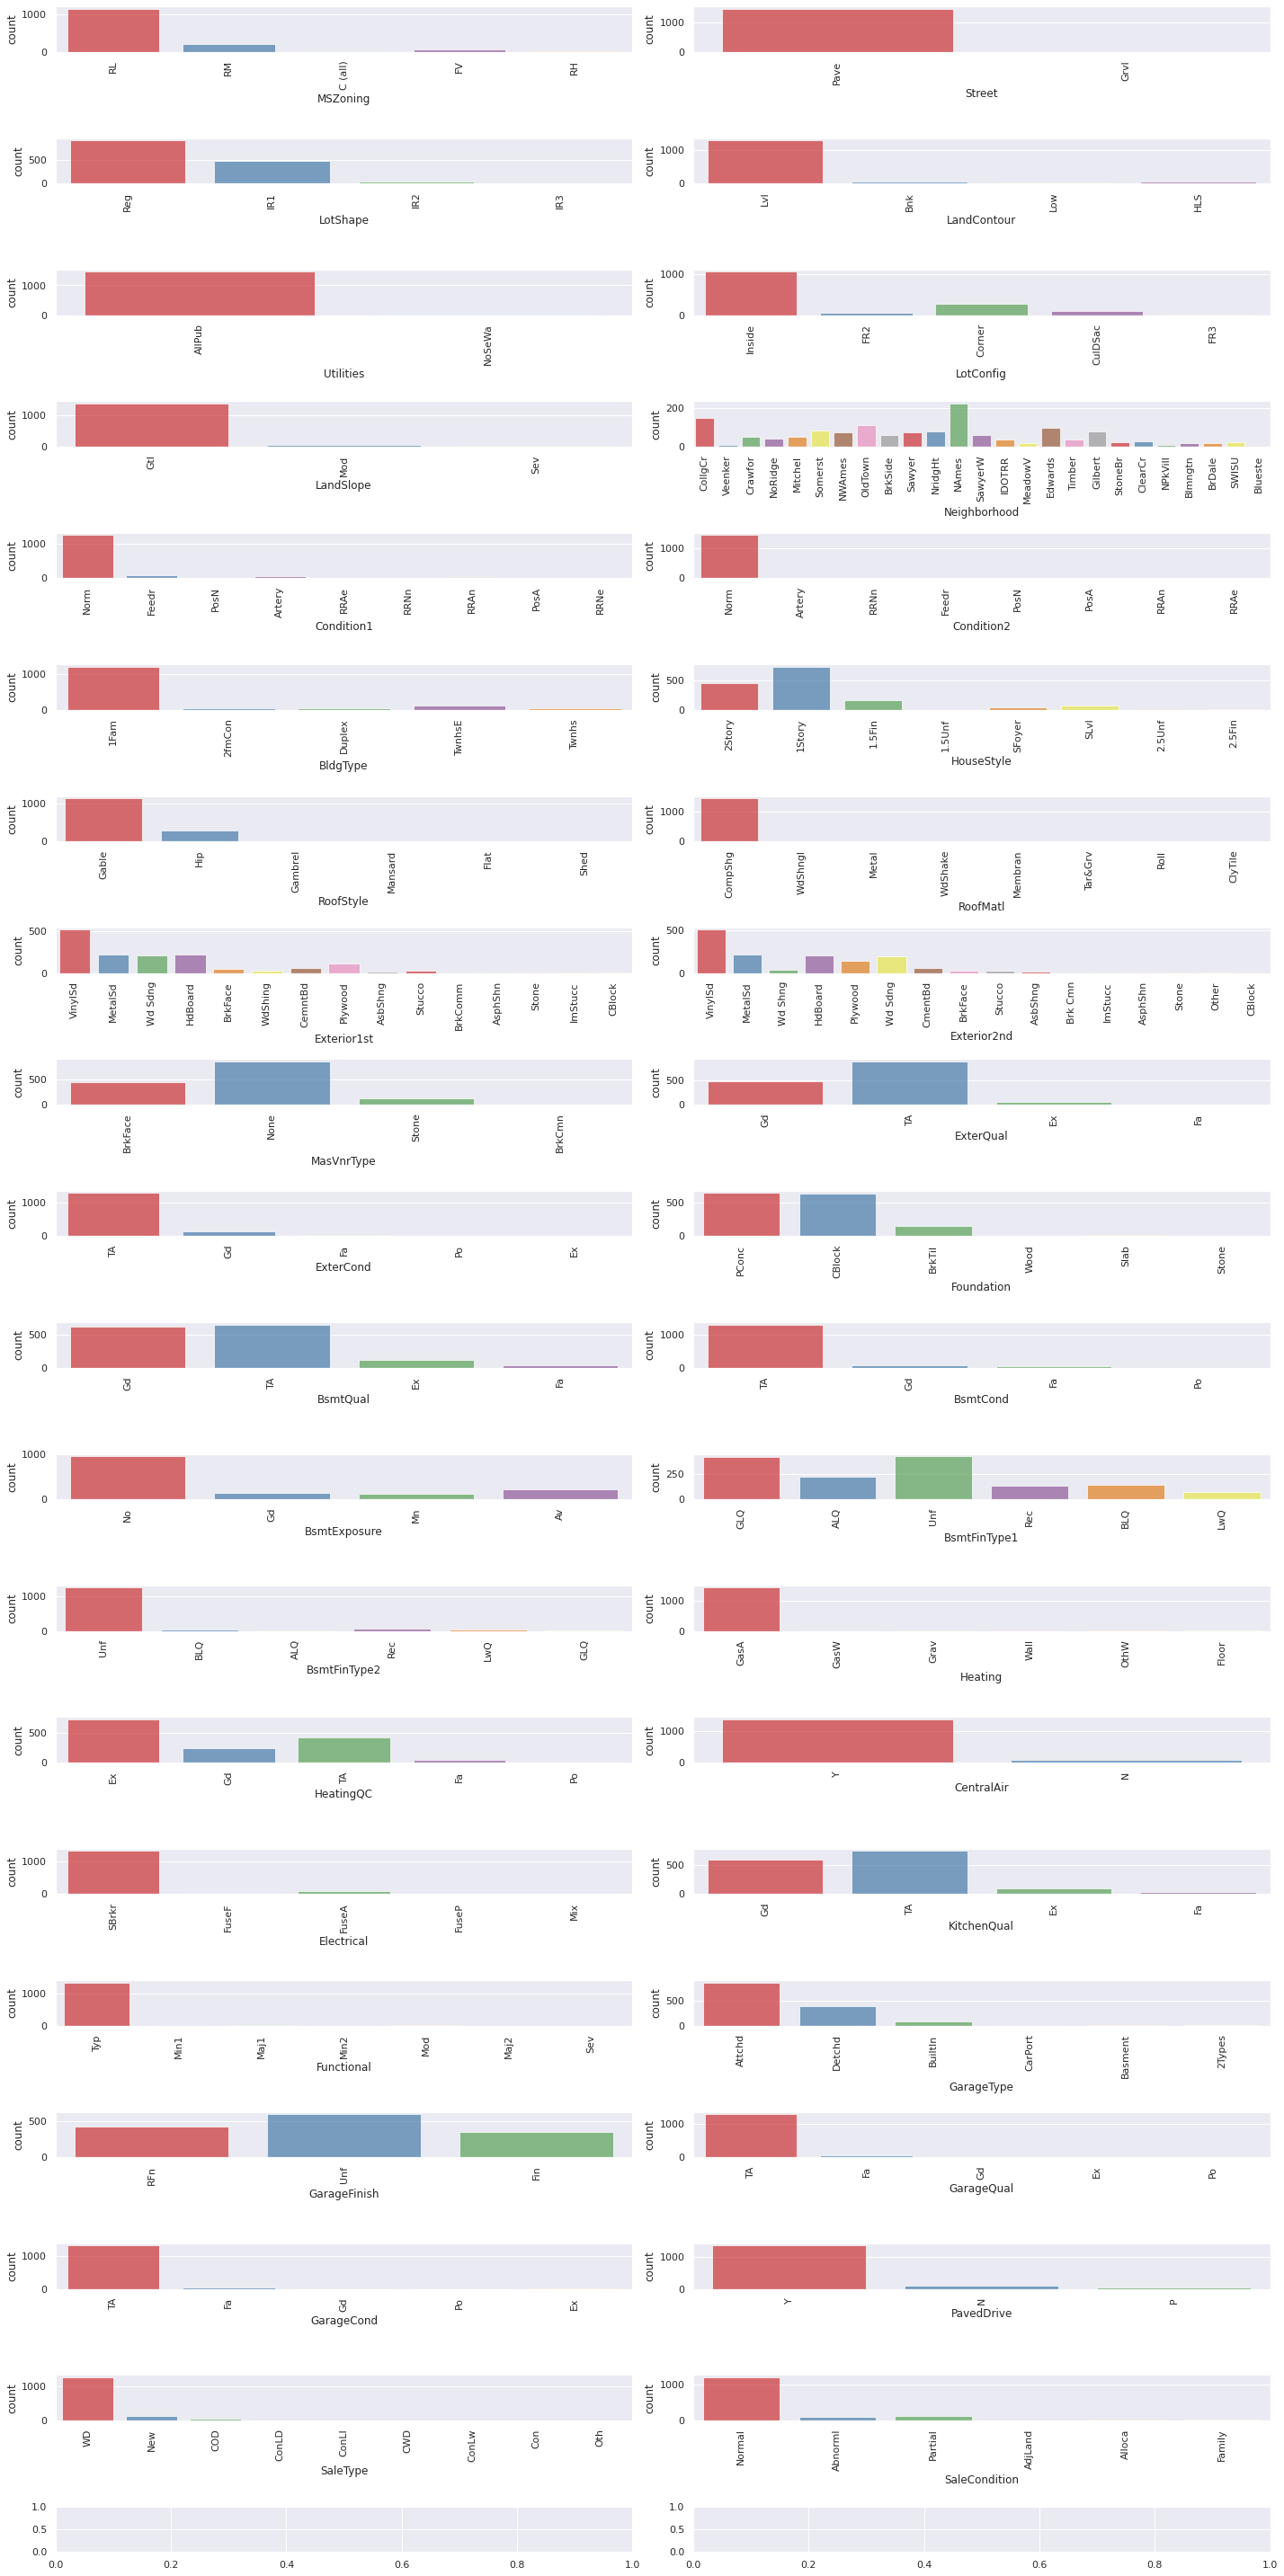

In [49]:
fig, axes = plt.subplots(round(len(df_train_categ.columns)/2), 2, figsize=(20, 40))

for i, ax in enumerate(fig.axes):
    # plot barplot of each feature
    if i < len(df_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=df_train_categ.columns[i], alpha=0.7, data=df_train_categ, ax=ax, palette = "Set1")

fig.tight_layout()

A count plot can be thought of as a histogram across a categorical, instead of quantitative variable. As a result, we don't want those predictors with a prevalent outcome because they don't contribute significantly to training our model. It's quite similar to the issue of quasi-constant variable we dealed with regarding numerical features. So, we will drop these concerned features.

In [50]:
cols_to_drop = [
    'Street',
    'LandContour',
    'Utilities',
    'LandSlope',
    'Condition2',
    'RoofMatl',
    'BsmtCond',
    'BsmtFinType2',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageQual',
    'GarageCond',
    'PavedDrive'
]

# Training set
df_train_categ.drop(cols_to_drop, axis=1, inplace=True)

# Test set
df_test_categ.drop(cols_to_drop, axis=1, inplace=True)

In [51]:
print(f"Training set shape (Categorical features): {df_train_categ.shape}\n")
print(f"Test set shape (Categorical features): {df_test_categ.shape}\n")

Training set shape (Categorical features): (1460, 24)

Test set shape (Categorical features): (1459, 23)



We are left now with exactly 24 categorical features in both data sets.

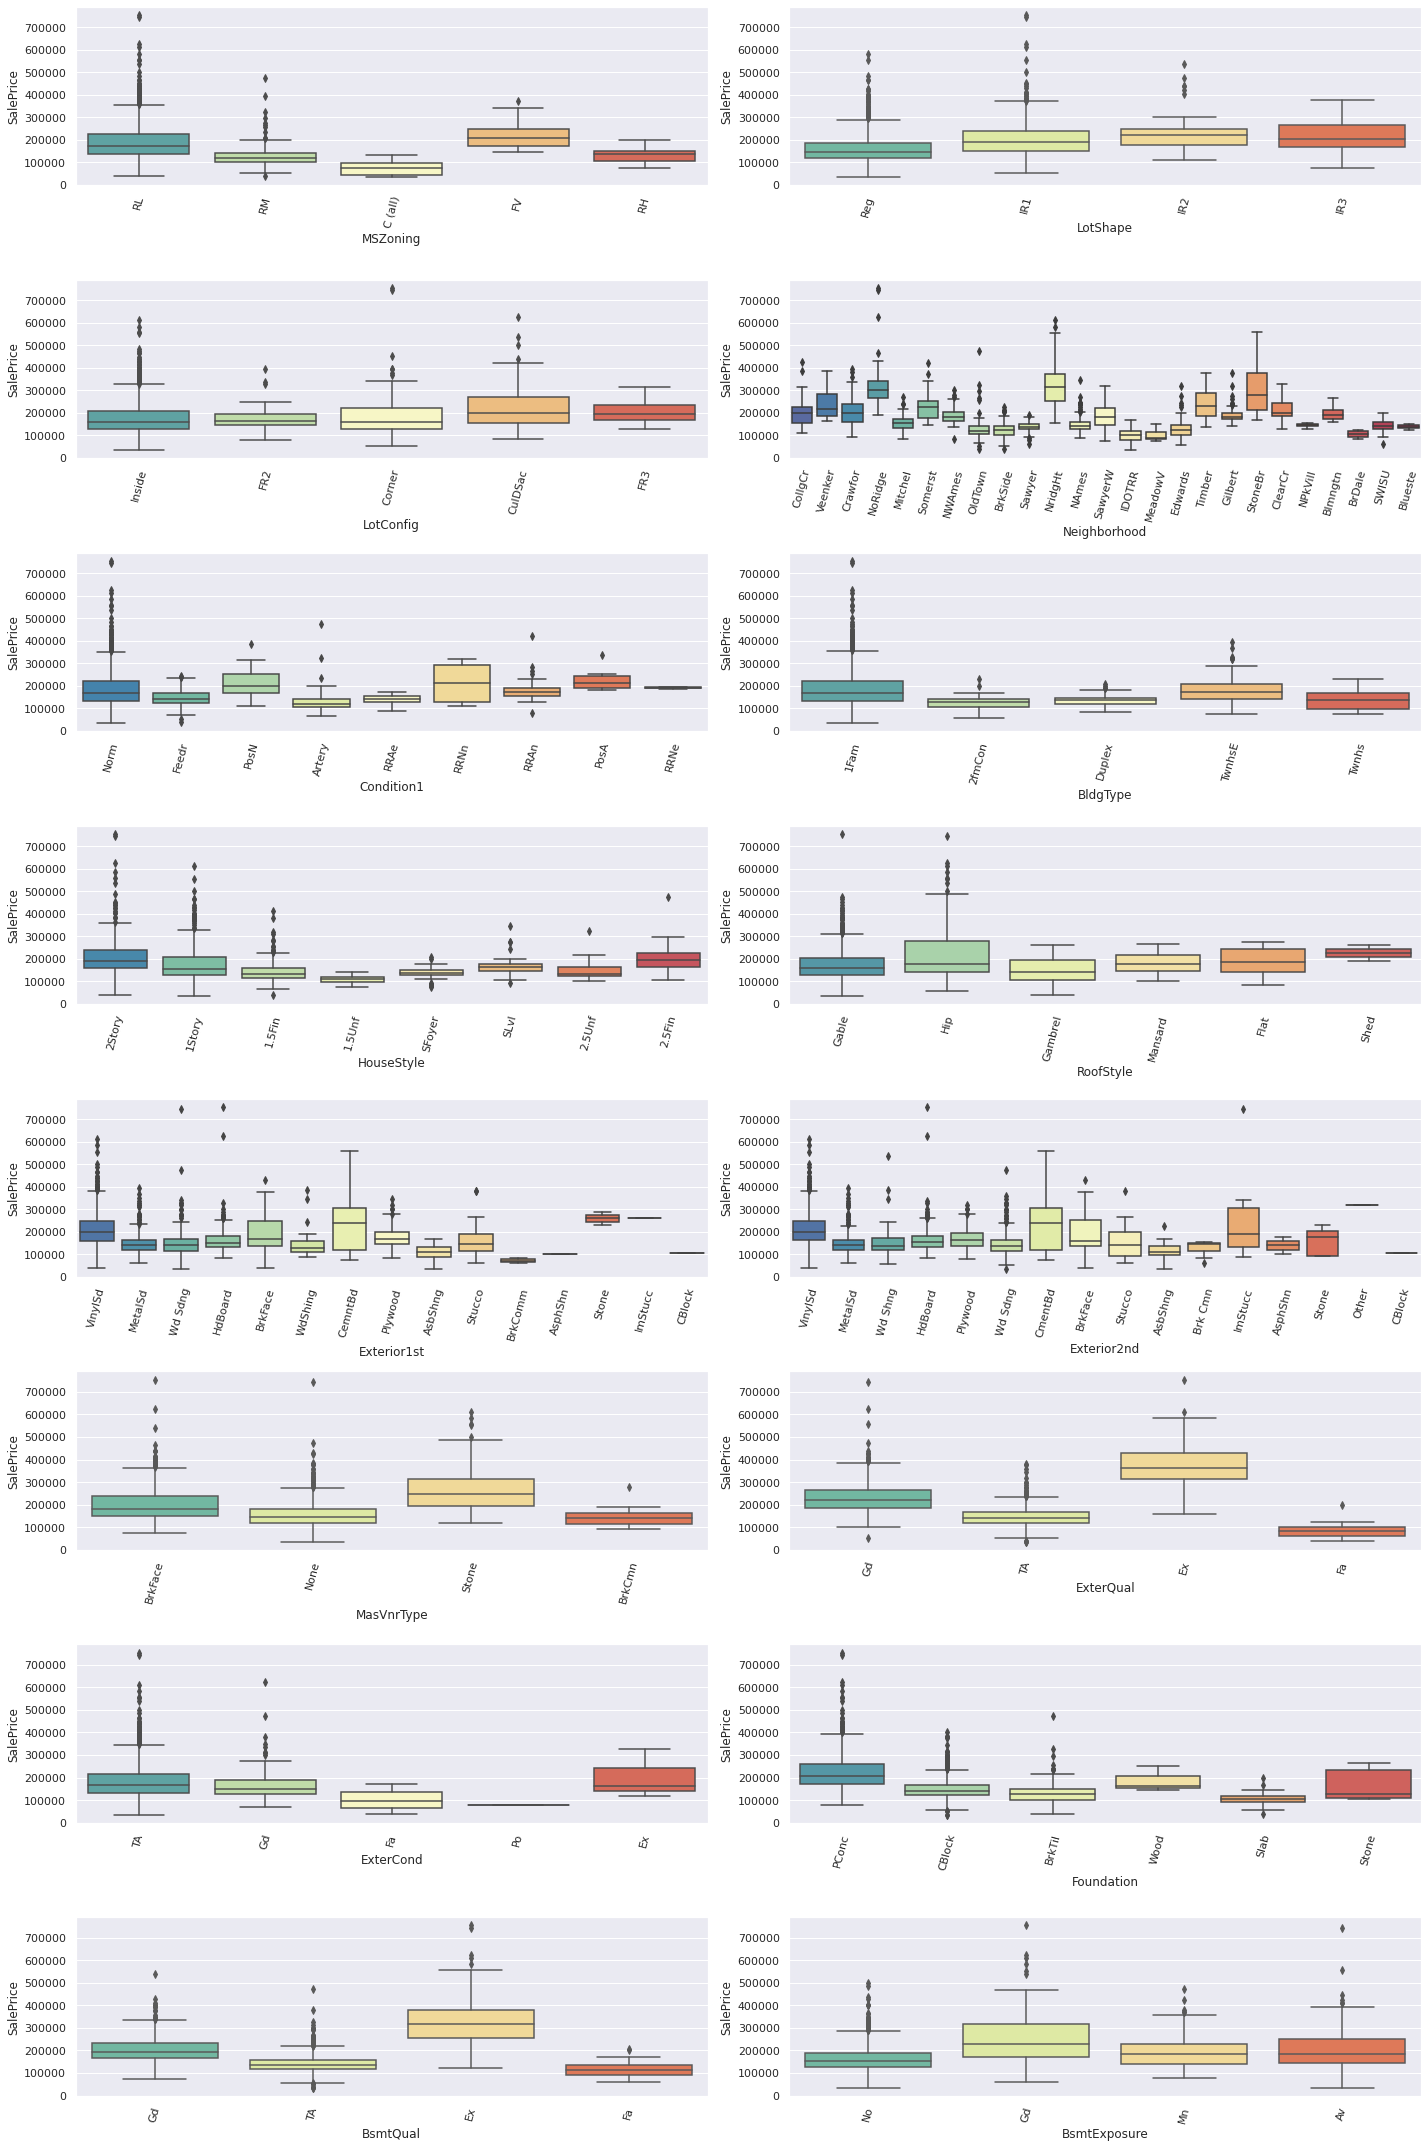

In [52]:
fig, axes = plt.subplots(
    round(len(df_train_categ.columns)/3), 2, figsize=(20, 30))

for i, ax in enumerate(fig.axes):
    # plot the variation of SalePrice in each feature
    if i < len(df_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
        sns.boxplot(x=df_train_categ.columns[i], y="SalePrice", data=df_train_categ, ax=ax, palette="Spectral_r")

fig.tight_layout()

There are three pairs of categorical variables for which the distribution of sale price is very similar:

"Exterior1st" and "Exterior2nd"

"ExterQual" and "MasVnrType"

"BsmtQual" and "BsmtExposure"

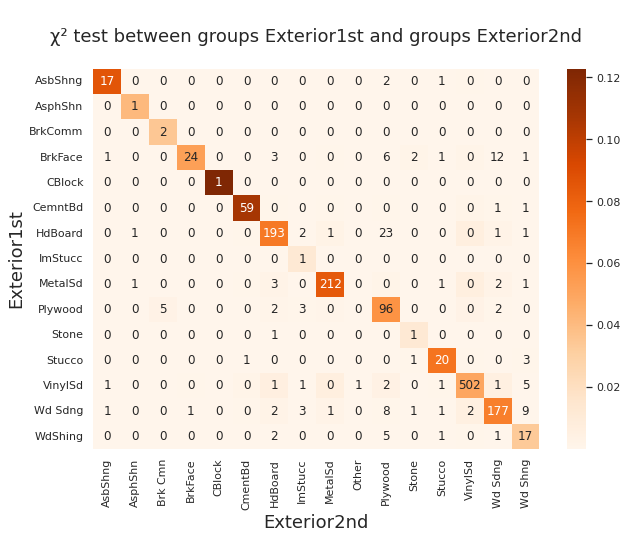

P-Value of the ChiSq Test bewteen Exterior1st and Exterior2nd is: 0.0



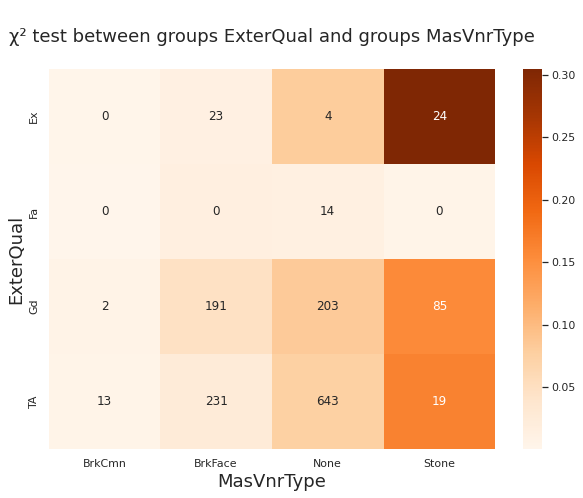

P-Value of the ChiSq Test bewteen ExterQual and MasVnrType is: 1.0187554679218715e-54



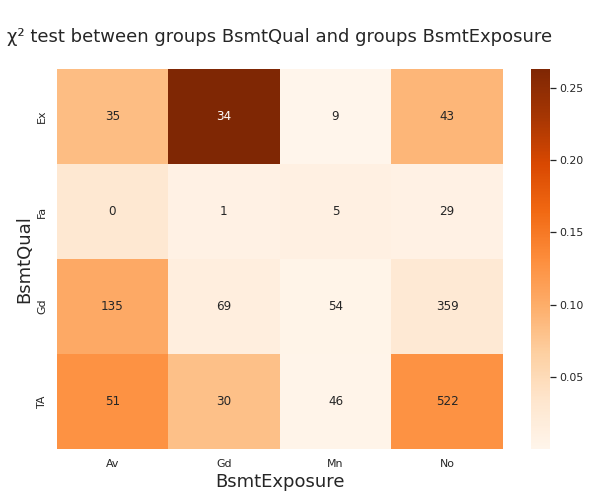

P-Value of the ChiSq Test bewteen BsmtQual and BsmtExposure is: 3.879215036512606e-32



In [53]:
# Plot contingency table

sns.set(rc={"figure.figsize": (10, 7)})

X = ["Exterior1st", "ExterQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtExposure"]

for i, j in zip(X, Y):

    # Contingency table
    cont = df_train_categ[[i, j]].pivot_table(
        index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(df_train_categ)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  # Replace NaN with 0 in the contingency table
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    # Plot contingency table
    p = sns.heatmap(table.iloc[:-1, :-1],
                    annot=c.iloc[:-1, :-1], fmt=".0f", cmap="Oranges")
    p.set_xlabel(j, fontsize=18)
    p.set_ylabel(i, fontsize=18)
    p.set_title(f"\nχ² test between groups {i} and groups {j}\n", size=18)
    plt.show()

    # Performing Chi-sq test
    CrosstabResult = pd.crosstab(
        index=df_train_categ[i], columns=df_train_categ[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    # P-Value is the Probability of H0 being True
    print(
        f"P-Value of the ChiSq Test bewteen {i} and {j} is: {ChiSqResult[1]}\n")

After performing the Chi-squared test for each pairs of variables considered, we see that there is strong co-dependency for each of these variables. Since highly dependent/correlated variables do not add much relevant new information with regards to the value of the target variable, we will drop one of each co-dependent variable from the dataset.

In [54]:
# Drop the one of each co-dependent variables
# Training set
df_train_categ.drop(Y, axis=1, inplace=True)

# Test set
df_test_categ.drop(Y, axis=1, inplace=True)

In [55]:
print(f"Training set shape (Categorical features): {df_train_categ.shape}\n")
print(f"Test set shape (Categorical features): {df_test_categ.shape}\n")

Training set shape (Categorical features): (1460, 21)

Test set shape (Categorical features): (1459, 20)



Eventually, we have 21 categorical features in our pool now. 

More than half of what we had initially has been dropped by conducting this cleaning operation.

## Missing data of Categorical features

### Training set

In [56]:
nb_row=df_train_categ.shape[0]
percentage_na_col_categ_train=df_train_categ.apply(lambda x:(x.notna().sum()/nb_row)*100,axis=0)

In [57]:
percentage_na_col_categ_train

MSZoning        100.00
LotShape        100.00
LotConfig       100.00
Neighborhood    100.00
Condition1      100.00
BldgType        100.00
HouseStyle      100.00
RoofStyle       100.00
Exterior1st     100.00
ExterQual       100.00
ExterCond       100.00
Foundation      100.00
BsmtQual         97.47
BsmtFinType1     97.47
HeatingQC       100.00
KitchenQual     100.00
GarageType       94.45
GarageFinish     94.45
SaleType        100.00
SaleCondition   100.00
SalePrice       100.00
dtype: float64

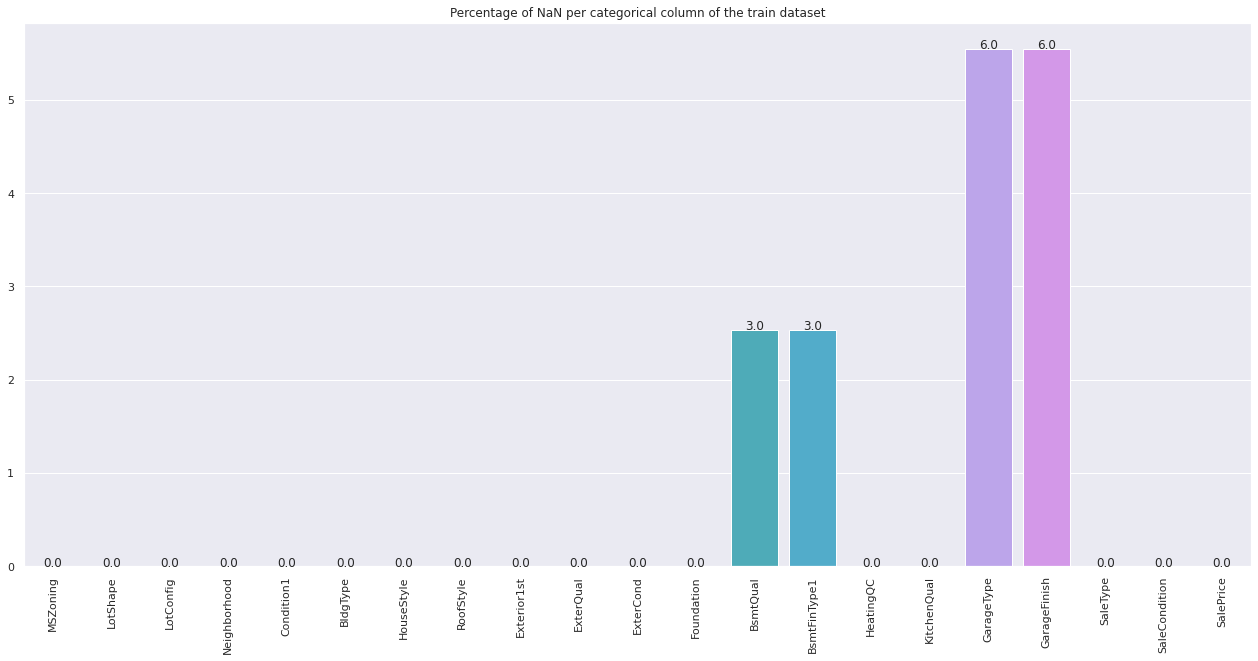

In [58]:
sns.set(font_scale=1)
plt.figure(figsize=(22,10))
plt.xticks(rotation=90)
nb_col=df_train_categ.shape[1]
ax=sns.barplot(x=percentage_na_col_categ_train.index,y=100-percentage_na_col_categ_train.values)
i=0
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+0.4,height,round(100-percentage_na_col_categ_train.values[i],0),ha='center')
    i+=1

plt.title('Percentage of NaN per categorical column of the train dataset')
plt.show()

In [59]:
# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"GarageType": df_train_categ["GarageType"].mode().iloc[0],
                   "GarageFinish": df_train_categ["GarageFinish"].mode().iloc[0],
                   "BsmtQual": df_train_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_train_categ["BsmtFinType1"].mode().iloc[0]}

df_train_categ = df_train_categ.fillna(value=categ_fill_null)

### Testing set

In [60]:
nb_row=df_test_categ.shape[0]
percentage_na_col_categ_test=df_test_categ.apply(lambda x:(x.notna().sum()/nb_row)*100,axis=0)

In [61]:
percentage_na_col_categ_test

MSZoning         99.73
LotShape        100.00
LotConfig       100.00
Neighborhood    100.00
Condition1      100.00
BldgType        100.00
HouseStyle      100.00
RoofStyle       100.00
Exterior1st      99.93
ExterQual       100.00
ExterCond       100.00
Foundation      100.00
BsmtQual         96.98
BsmtFinType1     97.12
HeatingQC       100.00
KitchenQual      99.93
GarageType       94.79
GarageFinish     94.65
SaleType         99.93
SaleCondition   100.00
dtype: float64

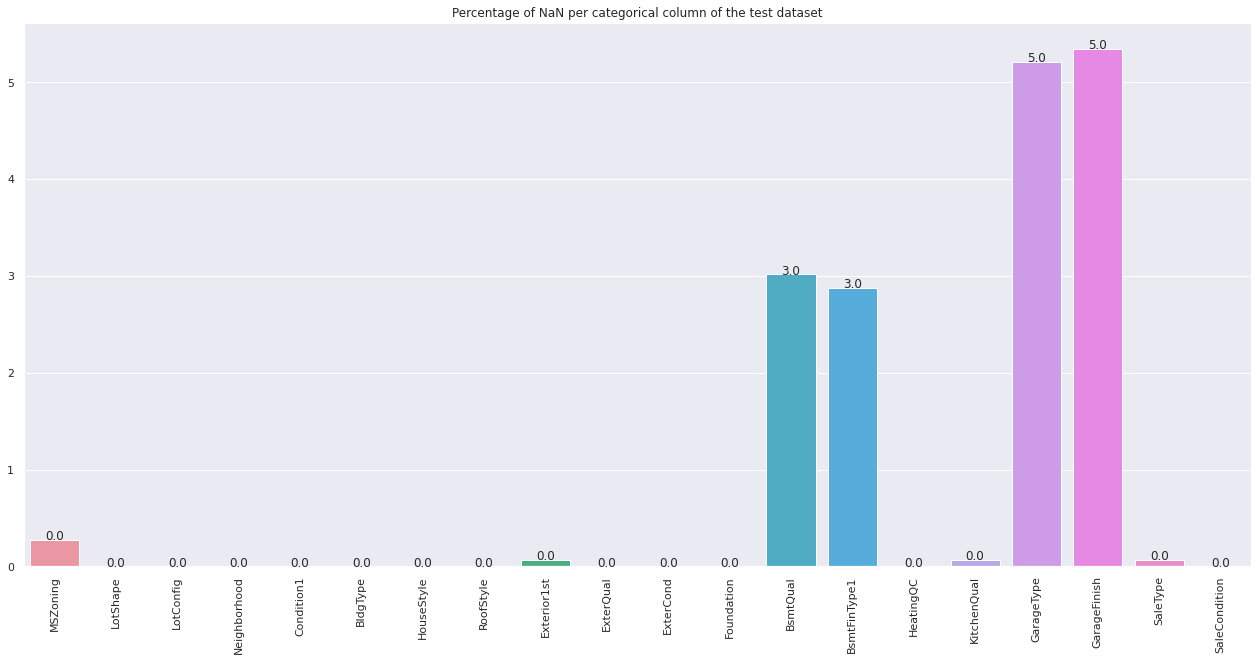

In [62]:
sns.set(font_scale=1)
plt.figure(figsize=(22,10))
plt.xticks(rotation=90)
nb_col=df_test_categ.shape[1]
ax=sns.barplot(x=percentage_na_col_categ_test.index,y=100-percentage_na_col_categ_test.values)
i=0
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+0.4,height,round(100-percentage_na_col_categ_test.values[i],0),ha='center')
    i+=1

plt.title('Percentage of NaN per categorical column of the test dataset')
plt.show()

Columns in the test dataset have also missing values, but none of them have more than 5% missing values. Therefore, we will fill in each NaN entry for each feature using it's corresponding modal class as we did before.

In [63]:
# Fill the NaN of each feature by the corresponding modal class

# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"GarageType": df_test_categ["GarageType"].mode().iloc[0],
                   "GarageFinish": df_test_categ["GarageFinish"].mode().iloc[0],
                   "BsmtQual": df_test_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_test_categ["BsmtFinType1"].mode().iloc[0],
                   "MSZoning": df_test_categ["MSZoning"].mode().iloc[0],
                   "Exterior1st": df_test_categ["Exterior1st"].mode().iloc[0],
                   "KitchenQual": df_test_categ["KitchenQual"].mode().iloc[0],
                   "SaleType": df_test_categ["SaleType"].mode().iloc[0]}

df_test_categ = df_test_categ.fillna(value=categ_fill_null)

In [64]:
print(f"Training set shape (Categorical features): {df_train_categ.shape}\n")
print(f"Test set shape (Categorical features): {df_test_categ.shape}\n")

Training set shape (Categorical features): (1460, 21)

Test set shape (Categorical features): (1459, 20)



In [65]:
# Drop the SalePrice column from the training dataset
df_train_categ.drop(["SalePrice"], axis = 1, inplace = True)

# Use get_dummies to transform the Categorical features into Binary features (Training dataset)
df_train_dummies = pd.get_dummies(df_train_categ)
df_train_dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [66]:
# Apply get_dummies to the test dataset as well
df_test_dummies = pd.get_dummies(df_test_categ)
df_test_dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [67]:
# Check if the column headings are the same in both data sets: data_train_dummies and data_test_dummies
dif_1 = [x for x in df_train_dummies.columns if x not in df_test_dummies.columns]
print(f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_dummies.columns if x not in df_train_dummies.columns]
print(f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: ['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone']

Features present in df_test_categ set and absent in df_train_categ: []


Three of these columns from the training dataset are not present in the test dataset. Thus they will be dropped from the training dataset to ensure that both datasets have exactly the same features.

In [68]:
# Drop the columns listed in dif_1 from data_train_dummies
df_train_dummies.drop(dif_1, axis=1, inplace=True)

# Check again if the column headings are the same in both data sets: data_train_dummies and data_test_dummies
dif_1 = [x for x in df_train_dummies.columns if x not in df_test_dummies.columns]
print(f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_dummies.columns if x not in df_test_dummies.columns]
print(f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: []

Features present in df_test_categ set and absent in df_train_categ: []


In [69]:
print(f"Training set shape (Categorical features): {df_train_dummies.shape}\n")
print(f"Test set shape (Categorical features): {df_test_dummies.shape}\n")

Training set shape (Categorical features): (1460, 137)

Test set shape (Categorical features): (1459, 137)



## Merge numerical and categorical features into one data set

In [70]:
# Training set
df_train_new = pd.concat([train_num_imputed, df_train_dummies], axis = 1)
print(f"Train set: {df_train_new.shape}")

# Test set
df_test_new = pd.concat([test_num_imputed, df_test_dummies], axis = 1)
print(f"Test set: {df_test_new.shape}")

Train set: (1460, 152)
Test set: (1459, 151)


# Feature engineering

The Year of construction and the Year of Remodelling variables will be transformed into new variables representing the Age of the House and the Age since the house was remodelled 

After the transformation, the variables "YearBuilt" and "YearRemodAdd" will be removed.

In [71]:
# Convert Year of construction to the Age of the house since the construction
df_train_new["AgeSinceConst"] = (df_train_new["YearBuilt"].max() - df_train_new["YearBuilt"])

df_test_new["AgeSinceConst"] = (df_test_new["YearBuilt"].max() - df_test_new["YearBuilt"])

# Drop "YearBuilt"
df_train_new.drop(["YearBuilt"], axis=1, inplace=True)
df_test_new.drop(["YearBuilt"], axis=1, inplace=True)

In [72]:
# Convert Year of remodeling to the Age of the house since the remodeling
df_train_new["AgeSinceRemod"] = (df_train_new["YearRemodAdd"].max() - df_train_new["YearRemodAdd"])

df_test_new["AgeSinceRemod"] = (df_test_new["YearRemodAdd"].max() - df_test_new["YearRemodAdd"])

# Drop "YearRemodAdd"
df_train_new.drop(["YearRemodAdd"], axis=1, inplace=True)
df_test_new.drop(["YearRemodAdd"], axis=1, inplace=True)

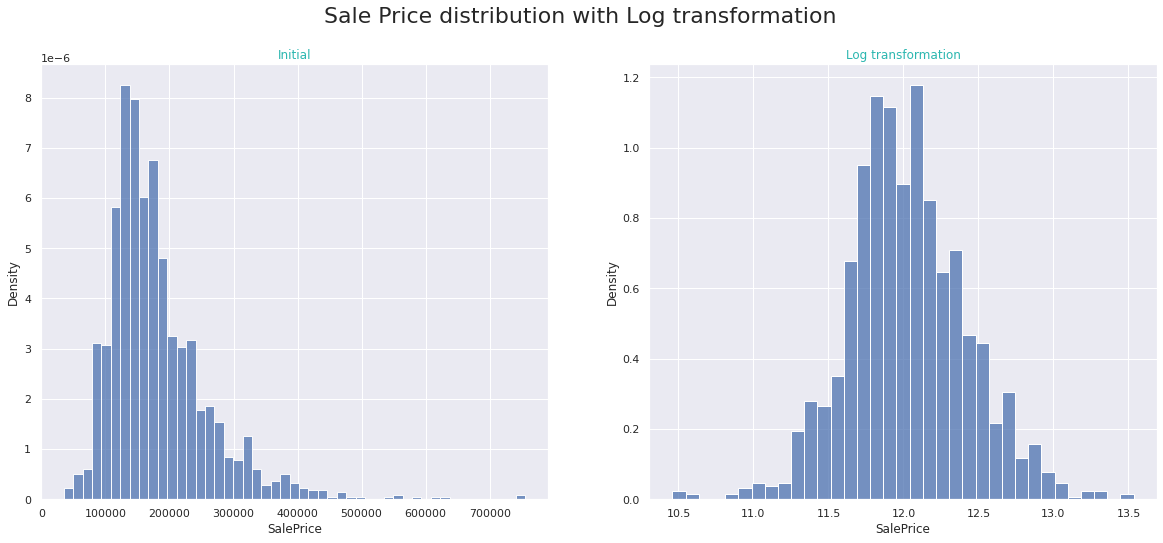

In [73]:
from sklearn.preprocessing import FunctionTransformer
Y = df_train_new[["SalePrice"]]
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='SalePrice', stat="density", ax=axes[0])
axes[0].set_title("Initial", color='#2cb7b0')
sns.histplot(data=Y_log, x='SalePrice', stat="density", ax=axes[1])
axes[1].set_title("Log transformation", color='#2cb7b0')
plt.suptitle("Sale Price distribution with Log transformation",fontsize=22)
plt.show()

No major change, we will keep the initial distribution without log transformation

# Modelling

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import timeit
# RMPSE
def rmpse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    return loss

In [75]:
# Model evaluation
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE, MAPE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmpse_cal = rmpse(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("RMPSE: ", rmpse_cal.round(3))
    print("MAPE: ", mape.round(5))
    print("R²: ", r_score.round(5))

## Split data into train and test set and Standardization

In [76]:
# Extract the features (X) and the target (y)
# Features (X)
X = df_train_new[[i for i in list(
    df_train_new.columns) if i != "SalePrice"]]
print(X.shape)

# Target (y)
y = df_train_new.loc[:, "SalePrice"]
print(y.shape)

(1460, 151)
(1460,)


In [77]:
from sklearn.model_selection import train_test_split
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(1168, 151)
y_train:(1168,)

X_test:(292, 151)
y_test:(292,)


In [78]:
from sklearn import preprocessing

# Standardize the data
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
# The same standardization is applied for df_test_new
df_test_new = std_scale.transform(df_test_new)

## Dummy regressor

In [79]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [80]:
# Prediction thanks to dummy regressor
# Model evaluation 
y_pred= dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  59568.25
MSE:  7861866593.52397
RMSE:  88667.16750592619
RMPSE:  0.534
MAPE:  0.35974
R²:  -0.02497


## Other models

In [81]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
 
dummy_reg = DummyRegressor(strategy="median")
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgbreg=XGBRegressor(random_state=42)


In [82]:

model = [dummy_reg,ridge, lasso, dt_reg,adaboost, bagging, gdboost, rdmforest,xgbreg]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    start_time = timeit.default_timer()
    y_pred = model.predict(X_test)
    time = timeit.default_timer() - start_time
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score, time)

results = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²","time"])
results.columns = ["Dummy Regressor", "Ridge", "Lasso", "DecisionTree",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest","XGBoost Regressor"]

results

,Dummy Regressor,Ridge,Lasso,DecisionTree,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost Regressor
MAE,"59,568.25","19,865.90","19,911.09","25,201.36","25,216.40","19,754.48","17,023.09","18,095.67","18,408.24"
MSE,"7,861,866,593.52","1,050,984,060.04","1,053,595,790.99","1,467,440,351.87","1,256,848,381.68","913,933,769.95","756,436,175.90","804,730,171.73","1,081,955,058.10"
RMSE,"88,667.17","32,418.88","32,459.14","38,307.18","35,452.06","30,231.34","27,503.38","28,367.77","32,893.08"
R²,-0.03,0.86,0.86,0.81,0.84,0.88,0.90,0.90,0.86
time,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00


The results of this modeling are showing that the best performance in terms of R squared (R²) correspond to Gradient Boosting. With regards to Residual Mean Square Error (RMSE), all these models are doing well except Gradient Boosting which achieved a better performance.

Thus, Gradient Boosting will be chosen to predict house prices on the test set of this Kaggle project.

In [83]:
results_t=results.transpose()

In [84]:
results_t.reset_index(inplace=True)

In [85]:
results_t.rename(columns={"index": "Model"},inplace=True)

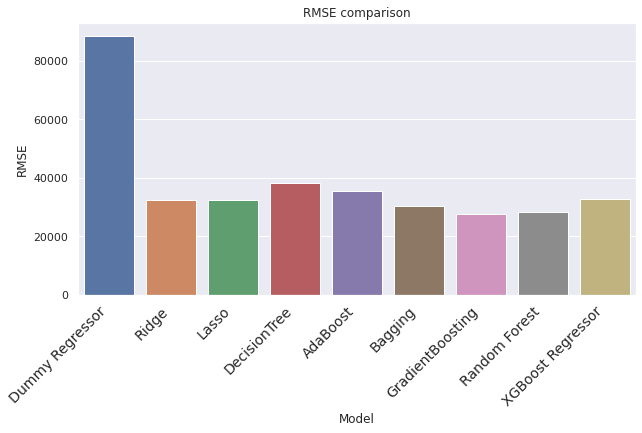

In [86]:
plt.figure(figsize=(10,5))
plt.title('RMSE comparison')
ax = sns.barplot(x = results_t['Model'], y = results_t['RMSE'])
ax.set_xticklabels(labels = results_t['Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

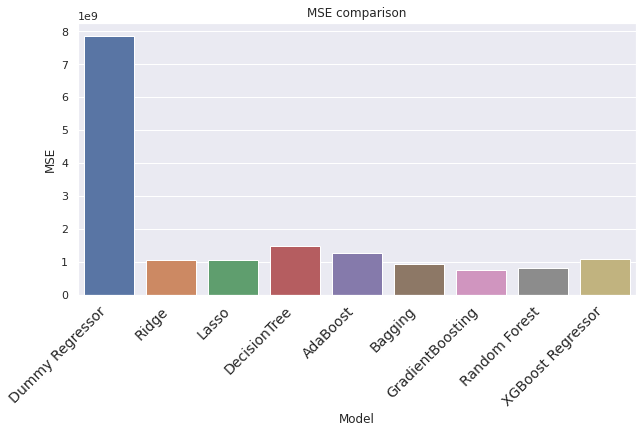

In [87]:
plt.figure(figsize=(10,5))
plt.title('MSE comparison')
ax = sns.barplot(x = results_t['Model'], y = results_t['MSE'])
ax.set_xticklabels(labels = results_t['Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

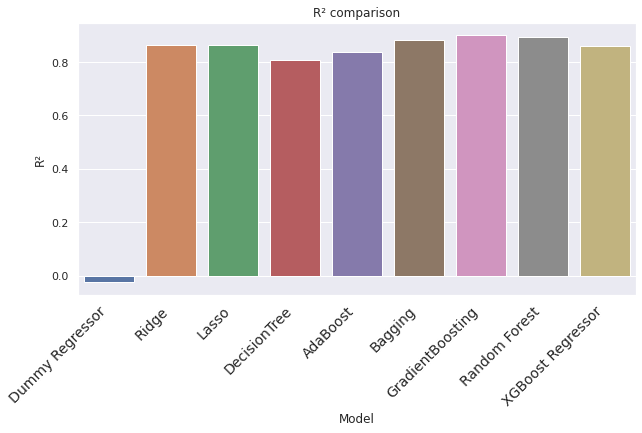

In [88]:
plt.figure(figsize=(10,5))
plt.title('R² comparison')
ax = sns.barplot(x = results_t['Model'], y = results_t['R²'])
ax.set_xticklabels(labels = results_t['Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

### Hyperparameters tuning

In [89]:
#from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV

param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    
    
}
search = GridSearchCV(
    GradientBoostingRegressor(random_state=42), param_distributions,
    scoring="neg_mean_absolute_error", n_jobs=2, cv=5
)
search.fit(X_train, y_train)
columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,mean_test_error,std_test_error
17,500,5,"16,918.19","1,438.25"
26,500,10,"16,949.75","1,557.39"
44,500,50,"16,949.75","1,557.39"
35,500,20,"16,949.75","1,557.39"
53,500,100,"16,949.75","1,557.39"
34,200,20,"17,023.01","1,548.77"
43,200,50,"17,023.01","1,548.77"
25,200,10,"17,023.01","1,548.77"
52,200,100,"17,023.01","1,548.77"
16,200,5,"17,097.33","1,408.49"


In [90]:
best_model=GradientBoostingRegressor(n_estimators=200,max_leaf_nodes=50)

In [91]:
best_model.fit(X_train,y_train)

GradientBoostingRegressor(max_leaf_nodes=50, n_estimators=200)

In [92]:
y_pred= best_model.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  16360.89394
MSE:  724532779.15218
RMSE:  26917.146564080344
RMPSE:  0.156
MAPE:  0.09527
R²:  0.90554


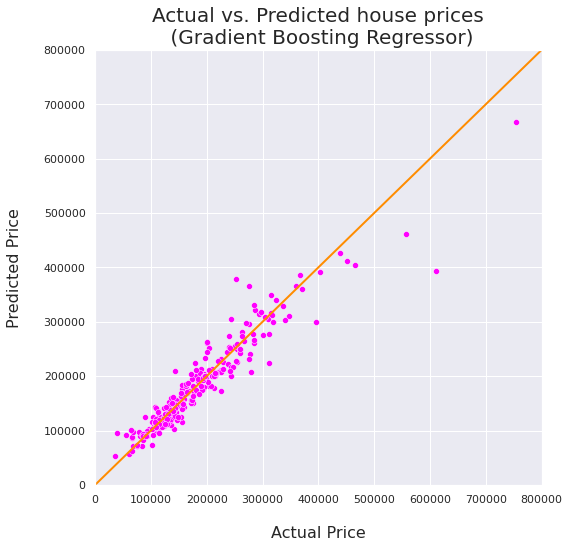

In [93]:
plt.figure(figsize=(8,8))
#sns.lineplot(x = [0,1.5e8], y = [0,1.5e8], alpha=0.5)
sns.scatterplot(y_test,y_pred, color='magenta')
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.title("Actual vs. Predicted house prices\n (Gradient Boosting Regressor)", fontsize=20)
plt.show()

### Residuals Plot

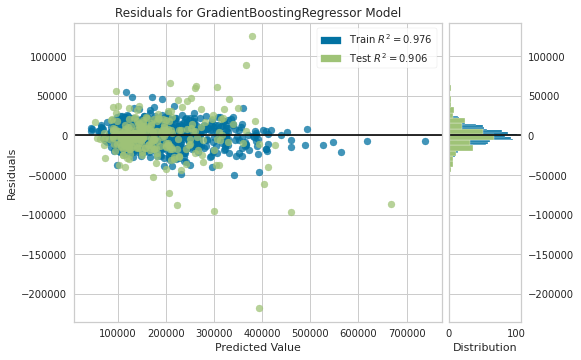

In [94]:
from yellowbrick.regressor import PredictionError, ResidualsPlot
visualizer = ResidualsPlot(best_model)
visualizer.fit(np.array(X_train), np.array(y_train).reshape(1168,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(292,))
visualizer.show();

### Feature Importance

In [95]:
feature_importance = best_model.feature_importances_

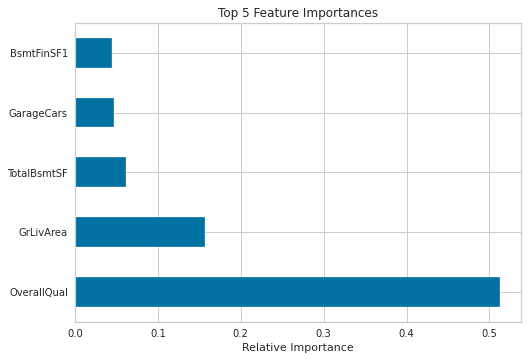

In [96]:
features_importances = pd.Series(feature_importance,index=X.columns)
features_importances.nlargest(5).plot(kind='barh', color='b')
plt.title('Top 5 Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

# Prediction

In [97]:
# Prediction of House Prices using Gradient Boosting Regressor Model

y_pred_final = best_model.predict(df_test_new)

output = pd.DataFrame({"Id": Id_test_list,"SalePrice": y_pred_final})

In [98]:
y_pred_final

array([114736.67221121, 154982.87277435, 180167.79146907, ...,
       151893.19840336, 128188.92034921, 227226.60671075])

In [99]:
# Save the output
output.to_csv("submission.csv", index=False)
output.head(10)

,Id,SalePrice
0,1461,"114,736.67"
1,1462,"154,982.87"
2,1463,"180,167.79"
3,1464,"189,687.04"
4,1465,"194,143.70"
5,1466,"178,659.21"
6,1467,"171,491.75"
7,1468,"165,606.16"
8,1469,"180,663.77"
9,1470,"130,435.24"
